<a href="https://colab.research.google.com/github/Chimata-Bhavya/DataAnalytics/blob/main/SentimentStockAnalysisCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stacked LSTM

In [414]:
pip install keras

In [415]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

In [416]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [417]:
file_path = r'/content/drive/MyDrive/stock_tweets.csv'
all_tweets = pd.read_csv(file_path)

In [418]:
file_path = r'/content/drive/MyDrive/stock_yfinance_data.csv'
all_stocks = pd.read_csv(file_path)

In [419]:
print(all_tweets.shape)
all_tweets.head()

(80793, 4)


Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.

In [420]:
stock_name = 'AMZN'
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
df.head()

(4089, 4)


Date  \
48351  2022-09-29 22:40:47+00:00   
48352  2022-09-29 22:23:54+00:00   
48353  2022-09-29 18:34:51+00:00   
48354  2022-09-29 15:57:59+00:00   
48355  2022-09-29 15:10:30+00:00   

                                                   Tweet Stock Name  \
48351  A group of lawmakers led by Sen. Elizabeth War...       AMZN   
48352  $NIO just because I'm down money doesn't mean ...       AMZN   
48353  Today’s drop in $SPX is a perfect example of w...       AMZN   
48354  Druckenmiller owned $CVNA this year \nMunger b...       AMZN   
48355  Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...       AMZN   

           Company Name  
48351  Amazon.com, Inc.  
48352  Amazon.com, Inc.  
48353  Amazon.com, Inc.  
48354  Amazon.com, Inc.  
48355  Amazon.com, Inc.

In [421]:
sent_df = df.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

Date  \
48351  2022-09-29 22:40:47+00:00   
48352  2022-09-29 22:23:54+00:00   
48353  2022-09-29 18:34:51+00:00   
48354  2022-09-29 15:57:59+00:00   
48355  2022-09-29 15:10:30+00:00   

                                                   Tweet Stock Name  \
48351  A group of lawmakers led by Sen. Elizabeth War...       AMZN   
48352  $NIO just because I'm down money doesn't mean ...       AMZN   
48353  Today’s drop in $SPX is a perfect example of w...       AMZN   
48354  Druckenmiller owned $CVNA this year \nMunger b...       AMZN   
48355  Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...       AMZN   

           Company Name sentiment_score Negative Neutral Positive  
48351  Amazon.com, Inc.                                            
48352  Amazon.com, Inc.                                            
48353  Amazon.com, Inc.                                            
48354  Amazon.com, Inc.                                            
48355  Amazon.com, Inc.

In [422]:
%%time
import nltk
nltk.download('vader_lexicon')


sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in sent_df.iterrows():
    try:
        sentence_i = unicodedata.normalize('NFKD', row['Tweet'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print(sent_df.loc[indx, 'Tweet'])
        break

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


CPU times: user 3.11 s, sys: 11.8 ms, total: 3.12 s
Wall time: 4.73 s


In [423]:
sent_df.head()

Date  \
48351  2022-09-29 22:40:47+00:00   
48352  2022-09-29 22:23:54+00:00   
48353  2022-09-29 18:34:51+00:00   
48354  2022-09-29 15:57:59+00:00   
48355  2022-09-29 15:10:30+00:00   

                                                   Tweet Stock Name  \
48351  A group of lawmakers led by Sen. Elizabeth War...       AMZN   
48352  $NIO just because I'm down money doesn't mean ...       AMZN   
48353  Today’s drop in $SPX is a perfect example of w...       AMZN   
48354  Druckenmiller owned $CVNA this year \nMunger b...       AMZN   
48355  Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...       AMZN   

           Company Name sentiment_score Negative Neutral Positive  
48351  Amazon.com, Inc.         -0.0772    0.084   0.841    0.075  
48352  Amazon.com, Inc.            0.25    0.158   0.684    0.158  
48353  Amazon.com, Inc.         -0.3182    0.164   0.728    0.108  
48354  Amazon.com, Inc.          0.2382    0.065   0.851    0.083  
48355  Amazon.com, Inc.          0.7783      0.0   0.799    0.201

In [424]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df['Date'] = sent_df['Date'].dt.date
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])

In [425]:
sent_df.head()

Date                                              Tweet  \
48351  2022-09-29  A group of lawmakers led by Sen. Elizabeth War...   
48352  2022-09-29  $NIO just because I'm down money doesn't mean ...   
48353  2022-09-29  Today’s drop in $SPX is a perfect example of w...   
48354  2022-09-29  Druckenmiller owned $CVNA this year \nMunger b...   
48355  2022-09-29  Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...   

      sentiment_score  
48351         -0.0772  
48352            0.25  
48353         -0.3182  
48354          0.2382  
48355          0.7783

In [426]:
# Group by 'Date' and calculate the mean of 'sentiment_score'
# sent_df['sentiment_score'] = pd.to_numeric(sent_df['sentiment_score'])
twitter_df = sent_df.groupby('Date').agg({
    'sentiment_score': 'mean'
}).reset_index()
twitter_df.head()

Date sentiment_score
0  2021-09-30         0.24648
1  2021-10-01        0.359338
2  2021-10-02         -0.0007
3  2021-10-03          0.8344
4  2021-10-04         0.25865

In [427]:
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name  
0  53868000       TSLA  
1  51094200       TSLA  
2  91449900       TSLA  
3  55297800       TSLA  
4  43898400       TSLA

In [428]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [429]:
# Merge with stock price data
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
twitter_df['Date'] = pd.to_datetime(twitter_df['Date']).dt.date
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date

final_df = stock_df.merge(twitter_df, how="left", on="Date", suffixes=('', '_2')).drop(columns=['Stock Name'])
final_df.head()

Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  165.800003  166.392502  163.699493  164.251999  164.251999   
1  2021-10-01  164.450500  165.458496  162.796997  164.162994  164.162994   
2  2021-10-04  163.969498  163.999496  158.812500  159.488998  159.488998   
3  2021-10-05  160.225006  163.036499  160.123001  161.050003  161.050003   
4  2021-10-06  160.676498  163.216995  159.931000  163.100494  163.100494   

     Volume sentiment_score  
0  56848000         0.24648  
1  56712000        0.359338  
2  90462000         0.25865  
3  65384000          0.0455  
4  50660000          0.1943

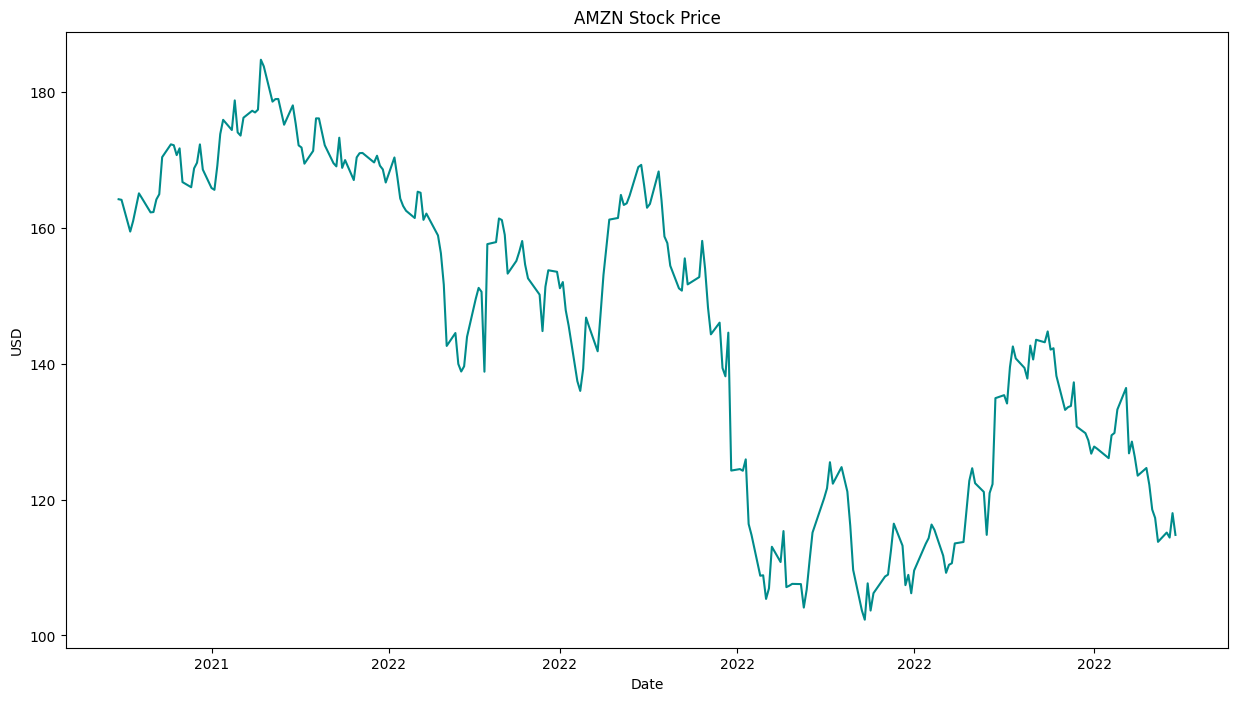

In [430]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

In [431]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [432]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [433]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [434]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [435]:
dataset = final_df.iloc[20:,:].reset_index(drop=True)
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 7)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [436]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

In [437]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from joblib import load

# Load scalers
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))


In [438]:
def build_stacked_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [439]:
def train_model(X_train, y_train, epochs, batch_size=32, callbacks=None):
    model = build_stacked_lstm_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=callbacks,  # Pass callbacks here
                        verbose=1)
    return model, history


In [440]:
def plot_results(Real_price, Predicted_price, index_train):
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("Training Results", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Train RMSE: ', RMSE)


In [441]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)
    print(predicted)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Test Data Prediction for {stock_name}", fontsize=20)
    plt.show()


In [442]:
# Cross-validation
from sklearn.model_selection import TimeSeriesSplit

n_splits = 5  # Number of splits for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)
train_rmse_list = []
test_rmse_list = []

Fold 1/5
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.5689 - val_loss: 0.2935
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.4433 - val_loss: 0.1083
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1886 - val_loss: 0.0660
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0456 - val_loss: 0.1528
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1064 - val_loss: 0.0345
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0176 - val_loss: 0.0026
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0150 - val_loss: 0.0061
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0364 - val_loss: 0.0069
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0390 - val_loss: 0.0021
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0221 - val_loss: 0.0085
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0095 - val_loss: 0.0315
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0136 - val_lo

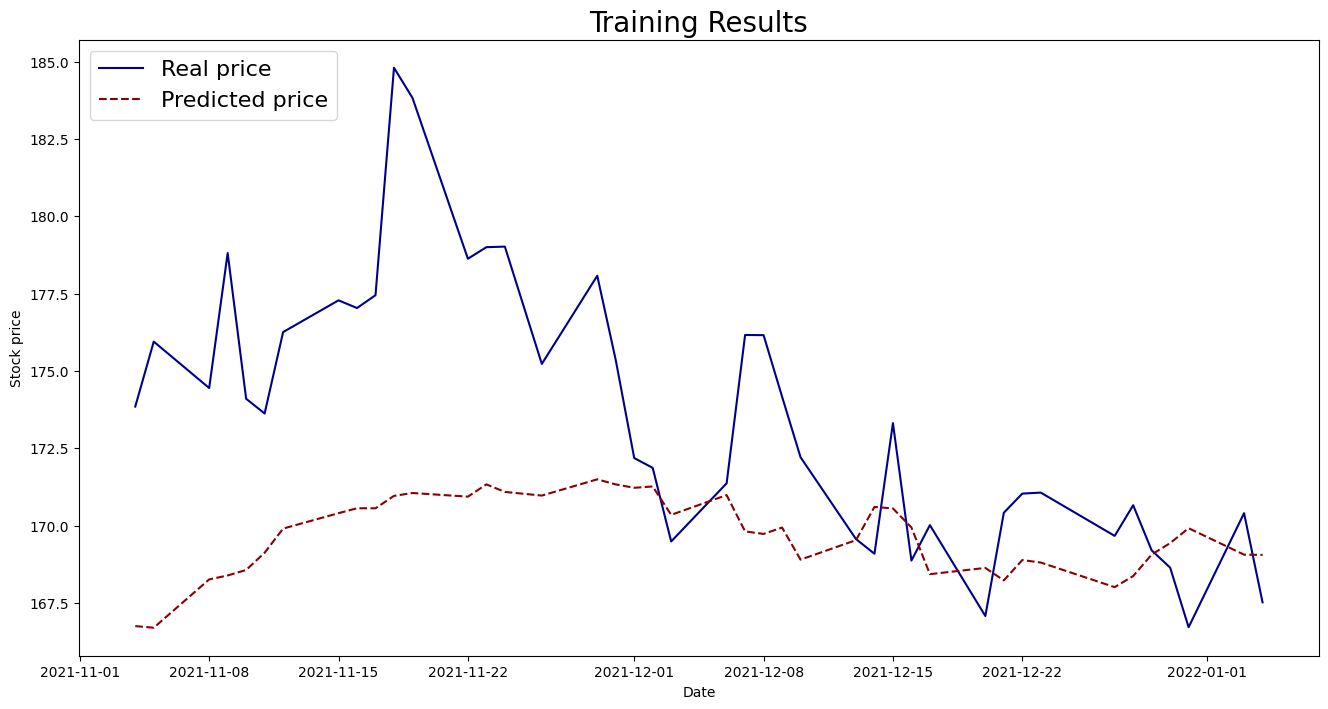

Train RMSE:  5.541791372817121
Test RMSE:  11.798702189880188
2022-01-05    169.198776
2022-01-06    169.156998
2022-01-07    168.815582
2022-01-10    168.116562
2022-01-11    167.881317
2022-01-12    166.869629
2022-01-13    166.640106
2022-01-14    167.105026
2022-01-18    166.612747
2022-01-19    167.876099
2022-01-20    168.210052
2022-01-21    167.815765
2022-01-24    166.153656
2022-01-25    164.894608
2022-01-26    161.879608
2022-01-27    156.226593
2022-01-28    151.953659
2022-01-31    152.722366
2022-02-01    155.129700
2022-02-02    155.358200
2022-02-03    156.535217
2022-02-04    158.420273
2022-02-07    159.991882
2022-02-08    158.568634
2022-02-09    154.165482
2022-02-10    150.571915
2022-02-11    158.808472
2022-02-14    164.249969
2022-02-15    165.429504
2022-02-16    165.570862
2022-02-17    164.234283
2022-02-18    163.062622
2022-02-22    163.389999
2022-02-23    164.968887
2022-02-24    164.953552
2022-02-25    164.084824
2022-02-28    162.258698
Name: predict

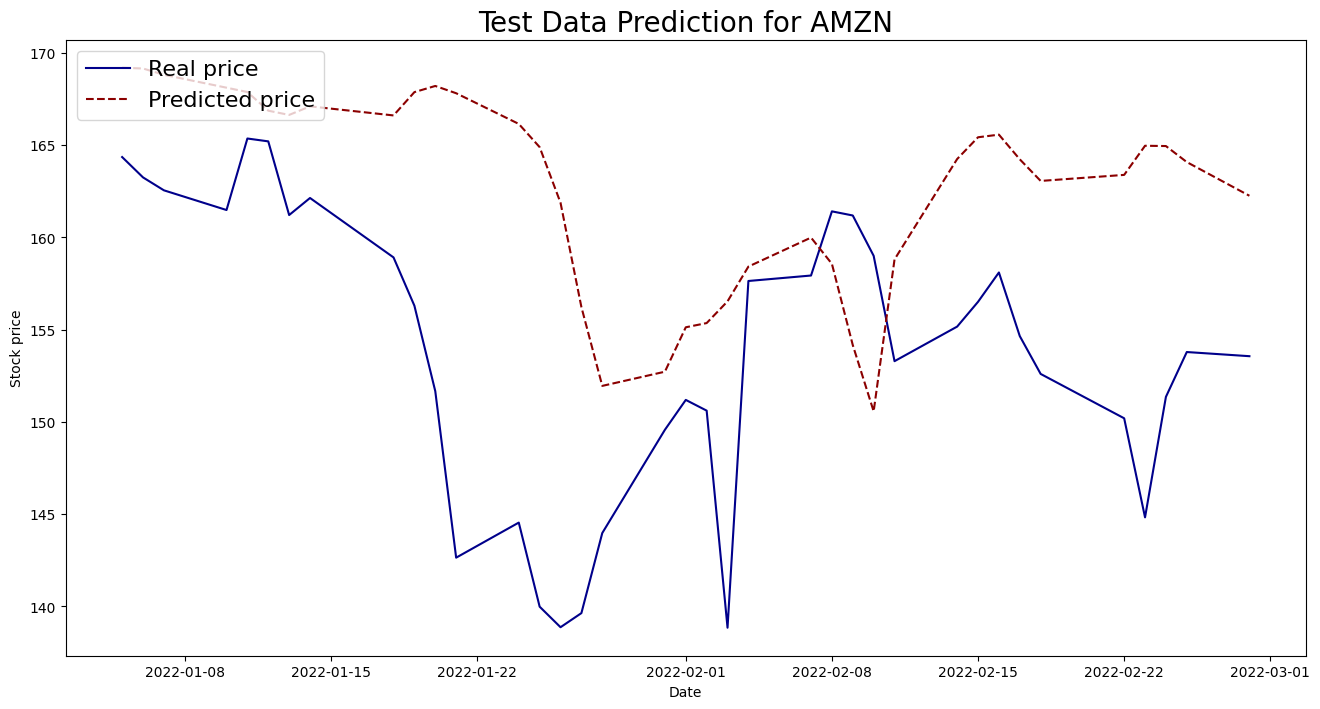

Train RMSE for fold 1: 0.1343578720086879
Test RMSE for fold 1: 0.2860534266717918
Fold 2/5
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 728ms/step - loss: 0.3795 - val_loss: 0.0627
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.2923 - val_loss: 0.0302
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1433 - val_loss: 0.0481
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0574 - val_loss: 0.1133
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0800 - val_loss: 0.0545
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0374 - val_loss: 0.0251
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0527 - val_loss: 0.0207
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0561 - val_loss: 0.0228
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0508 - val_loss: 0.0322
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0370 - val_loss: 0.0471
Epoch 10: early stopping
Restoring model weights from the end of the best ep

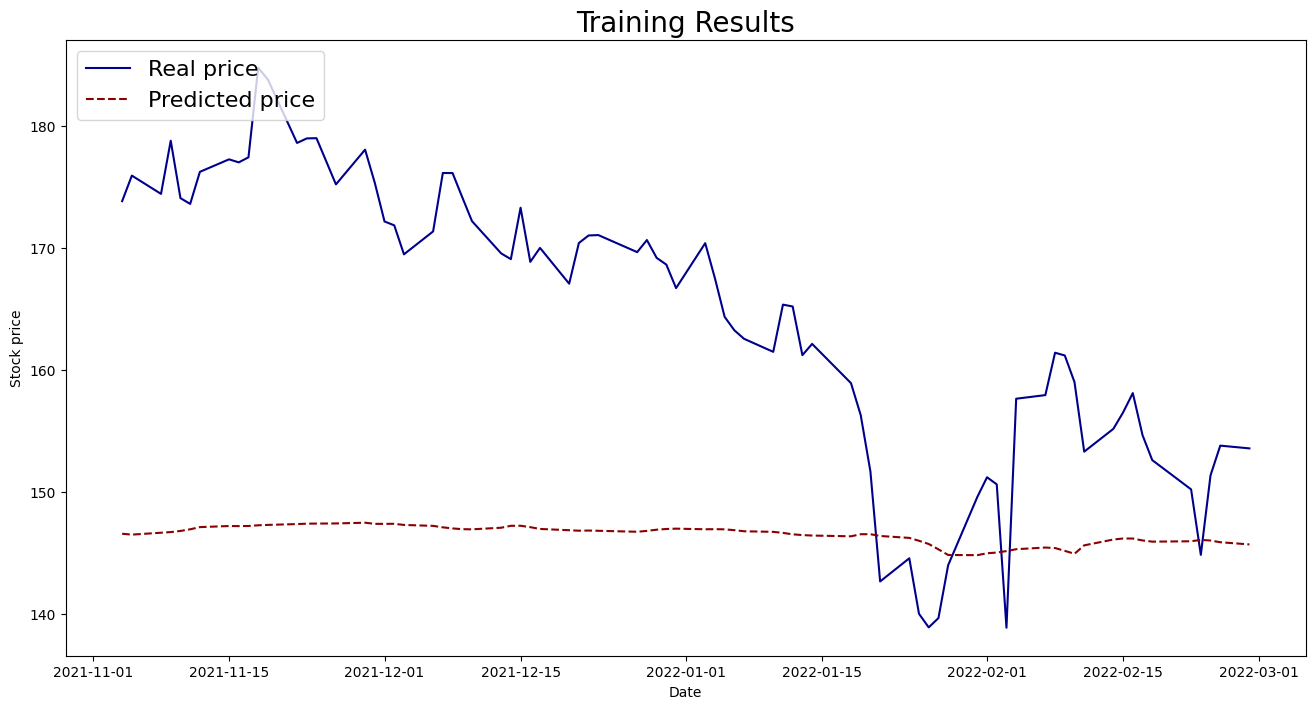

Train RMSE:  20.967047617726145
Test RMSE:  12.608472774392311
2022-03-01    145.537430
2022-03-02    145.480270
2022-03-03    145.524124
2022-03-04    145.793350
2022-03-07    145.804260
2022-03-08    145.744263
2022-03-09    145.603516
2022-03-10    145.377228
2022-03-11    145.105072
2022-03-14    144.867508
2022-03-15    144.836227
2022-03-16    145.028519
2022-03-17    145.201630
2022-03-18    145.352112
2022-03-21    145.338211
2022-03-22    145.527039
2022-03-23    145.796310
2022-03-24    146.036789
2022-03-25    146.202118
2022-03-28    146.400238
2022-03-29    146.490692
2022-03-30    146.526901
2022-03-31    146.560181
2022-04-01    146.654175
2022-04-04    146.717926
2022-04-05    146.716156
2022-04-06    146.627319
2022-04-07    146.553680
2022-04-08    146.552094
2022-04-11    146.536438
2022-04-12    146.349167
2022-04-13    146.084839
2022-04-14    146.004333
2022-04-18    145.924652
2022-04-19    145.821594
2022-04-20    145.845047
2022-04-21    145.882645
Name: predic

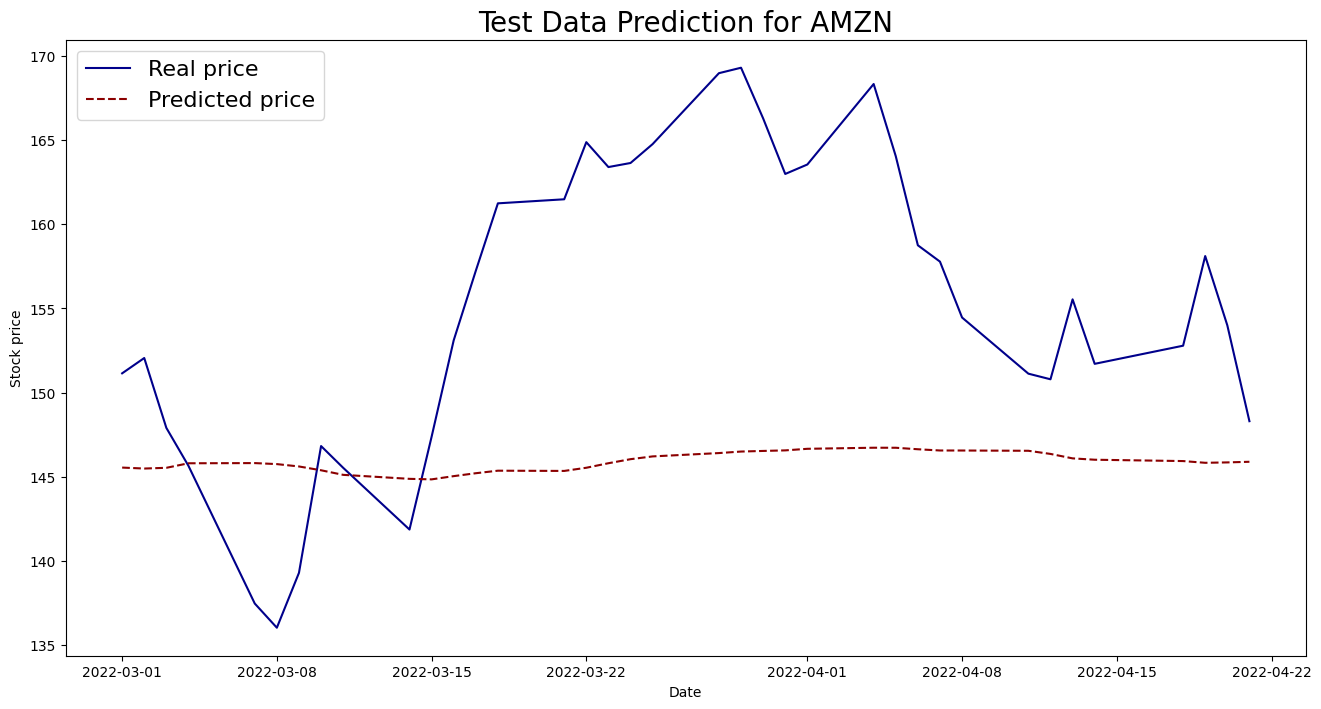

Train RMSE for fold 2: 0.5083351924738833
Test RMSE for fold 2: 0.3056859250275485
Fold 3/5
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - loss: 0.2886 - val_loss: 0.1113
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1673 - val_loss: 0.0315
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0589 - val_loss: 0.0551
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0464 - val_loss: 0.0269
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0520 - val_loss: 0.0294
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0521 - val_loss: 0.0279
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0359 - val_loss: 0.0464
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0348 - val_loss: 0.0309
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0337 - val_loss: 0.0349
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0300 - val_loss: 0.0354
Epoch 10: early stopping
Restoring model weights from the end of the best ep

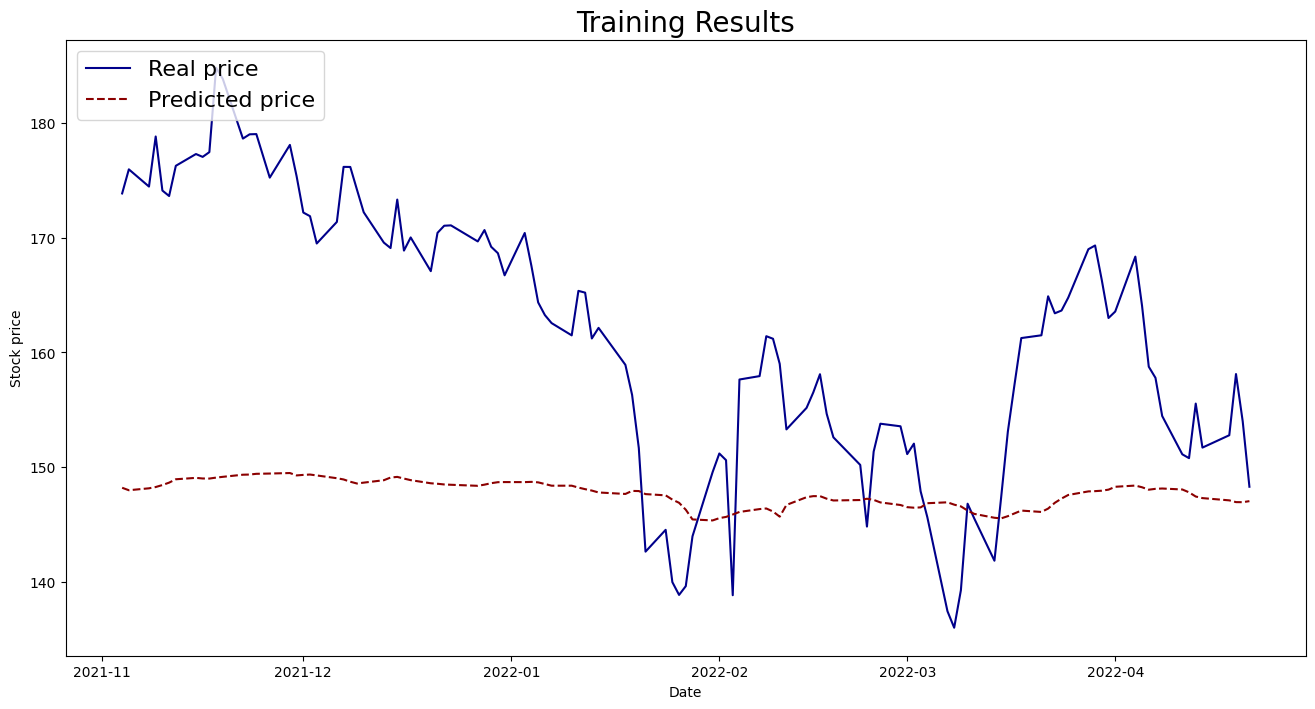

Train RMSE:  17.41421646495669
Test RMSE:  28.082499125786907
2022-04-22    147.089264
2022-04-25    147.153763
2022-04-26    147.222595
2022-04-27    146.889343
2022-04-28    146.457397
2022-04-29    146.119064
2022-05-02    145.968048
2022-05-03    145.519318
2022-05-04    145.072678
2022-05-05    144.502106
2022-05-06    143.495132
2022-05-09    143.849701
2022-05-10    143.975906
2022-05-11    143.610443
2022-05-12    143.125473
2022-05-13    142.906799
2022-05-16    142.633453
2022-05-17    142.628464
2022-05-18    142.521881
2022-05-19    142.592361
2022-05-20    142.943771
2022-05-23    143.044586
2022-05-24    142.970215
2022-05-25    142.718170
2022-05-26    142.652756
2022-05-27    142.466278
2022-05-31    142.464737
2022-06-01    142.462418
2022-06-02    142.731750
2022-06-03    143.050156
2022-06-06    143.311325
2022-06-07    143.561111
2022-06-08    143.840347
2022-06-09    143.940643
2022-06-10    143.933990
2022-06-13    143.903137
2022-06-14    143.855148
Name: predict

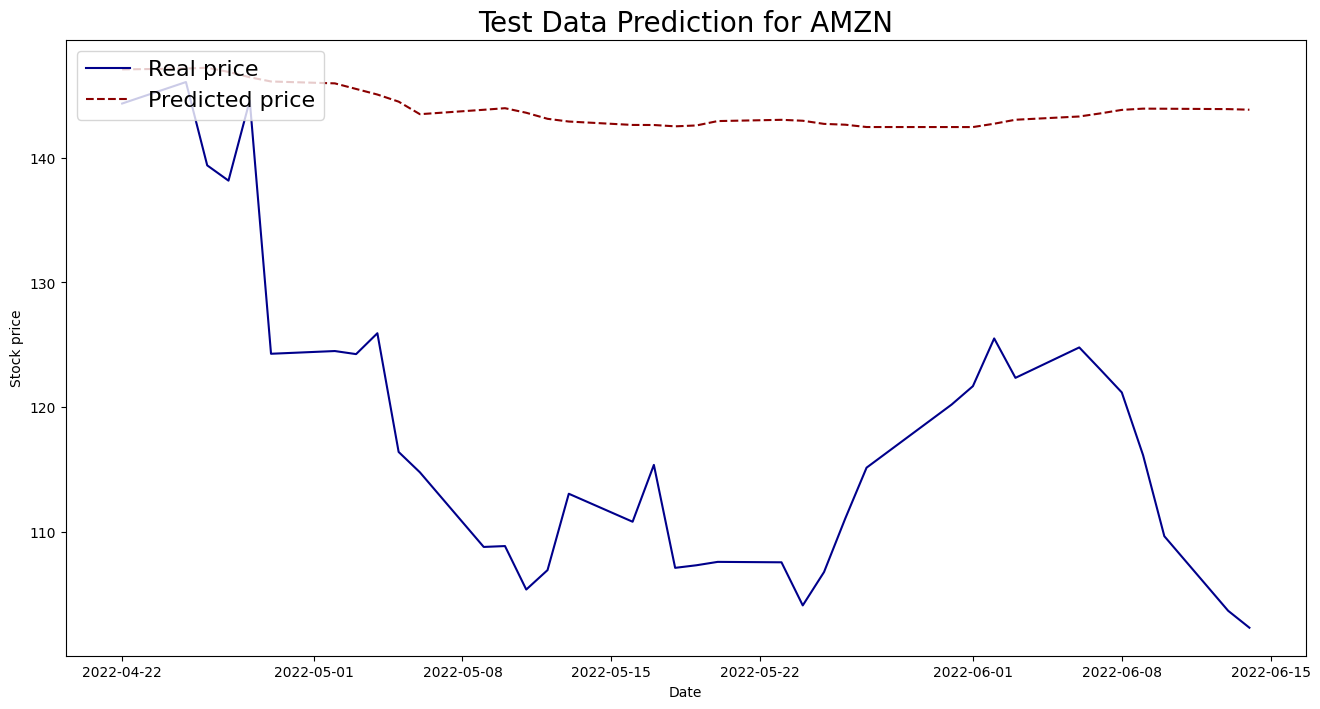

Train RMSE for fold 3: 0.42219866393027394
Test RMSE for fold 3: 0.6808456600856136
Fold 4/5
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 0.2283 - val_loss: 0.5188
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0988 - val_loss: 0.3530
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0751 - val_loss: 0.4022
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0600 - val_loss: 0.3630
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0451 - val_loss: 0.2685
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0377 - val_loss: 0.2591
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0298 - val_loss: 0.2700
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0294 - val_loss: 0.2516
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0303 - val_loss: 0.2775
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0277 - val_loss: 0.3262
Epoch 10: early stopping
Restoring model weights from the end of the best e

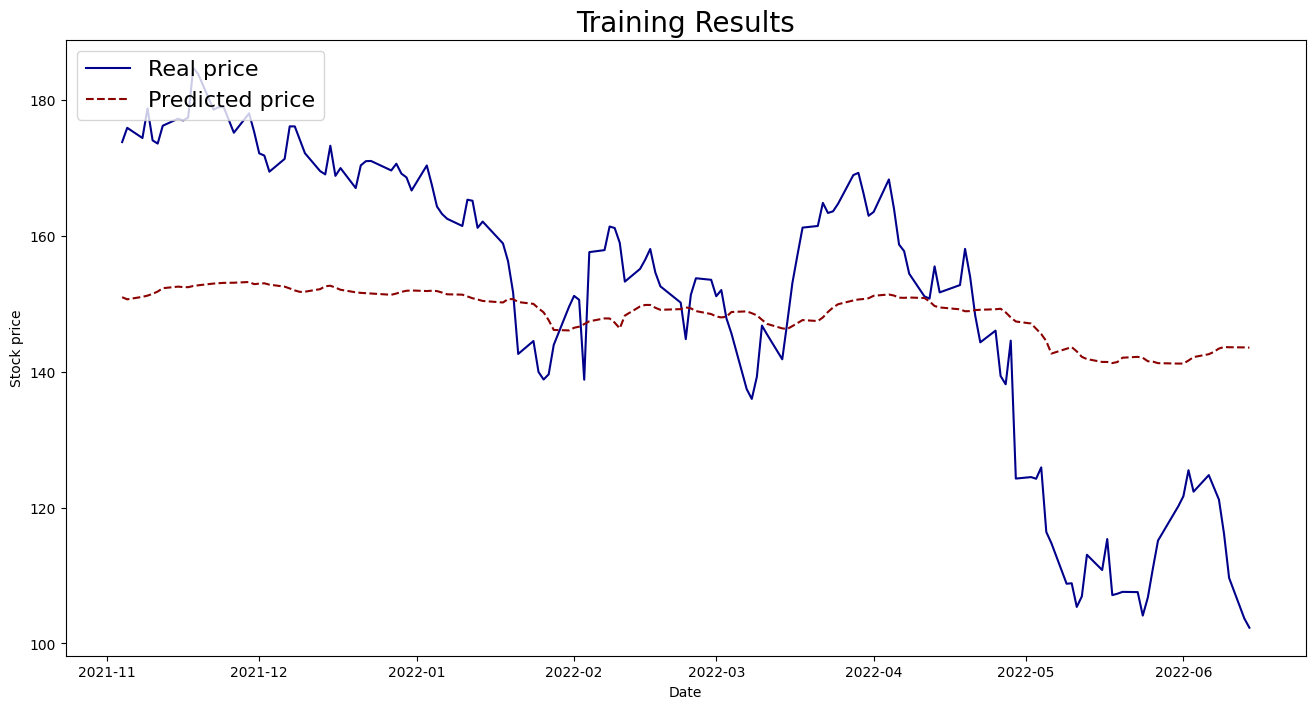

Train RMSE:  18.903995805894755
Test RMSE:  26.559406109257342
2022-06-15    143.198837
2022-06-16    142.429642
2022-06-17    141.539841
2022-06-21    141.100677
2022-06-22    141.250137
2022-06-23    141.339554
2022-06-24    141.273102
2022-06-27    141.495636
2022-06-28    141.959457
2022-06-29    142.169800
2022-06-30    142.475418
2022-07-01    142.579926
2022-07-05    142.366058
2022-07-06    141.925140
2022-07-07    141.824097
2022-07-08    141.690674
2022-07-11    142.197525
2022-07-12    142.465363
2022-07-13    142.842010
2022-07-14    142.942307
2022-07-15    142.736282
2022-07-18    142.396622
2022-07-19    142.214920
2022-07-20    142.158279
2022-07-21    142.437302
2022-07-22    142.679260
2022-07-25    143.125748
2022-07-26    143.473877
2022-07-27    143.880081
2022-07-28    144.115463
2022-07-29    143.977890
2022-08-01    143.631516
2022-08-02    143.385834
2022-08-03    143.885849
2022-08-04    144.412247
2022-08-05    145.347214
2022-08-08    146.005051
Name: predic

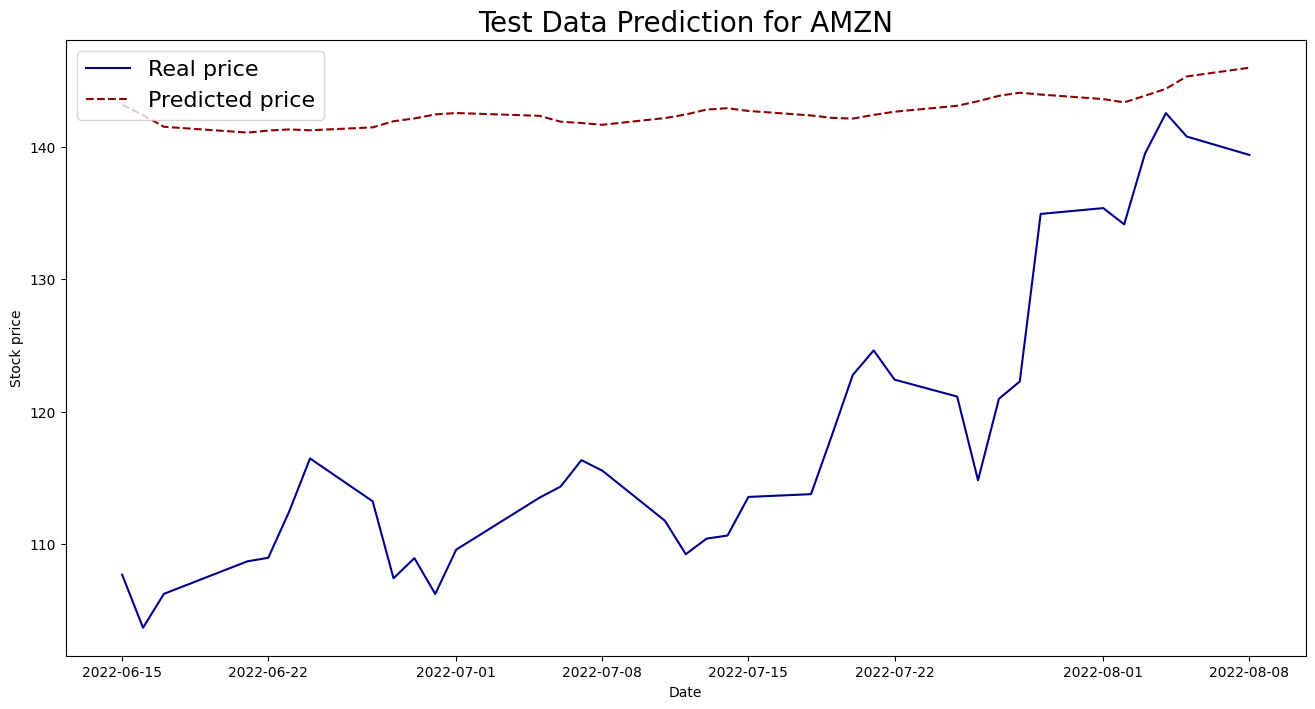

Train RMSE for fold 4: 0.45831758344470697
Test RMSE for fold 4: 0.6439190547283977
Fold 5/5
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.2861 - val_loss: 0.3645
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1407 - val_loss: 0.1145
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0564 - val_loss: 0.0501
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0529 - val_loss: 0.1648
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0483 - val_loss: 0.0496
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0412 - val_loss: 0.0579
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0444 - val_loss: 0.0506
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0387 - val_loss: 0.0490
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0366 - val_loss: 0.0605
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0352 - val_loss: 0.0627
Epoch 10: early stopping
Restoring model weights from the end of the best e

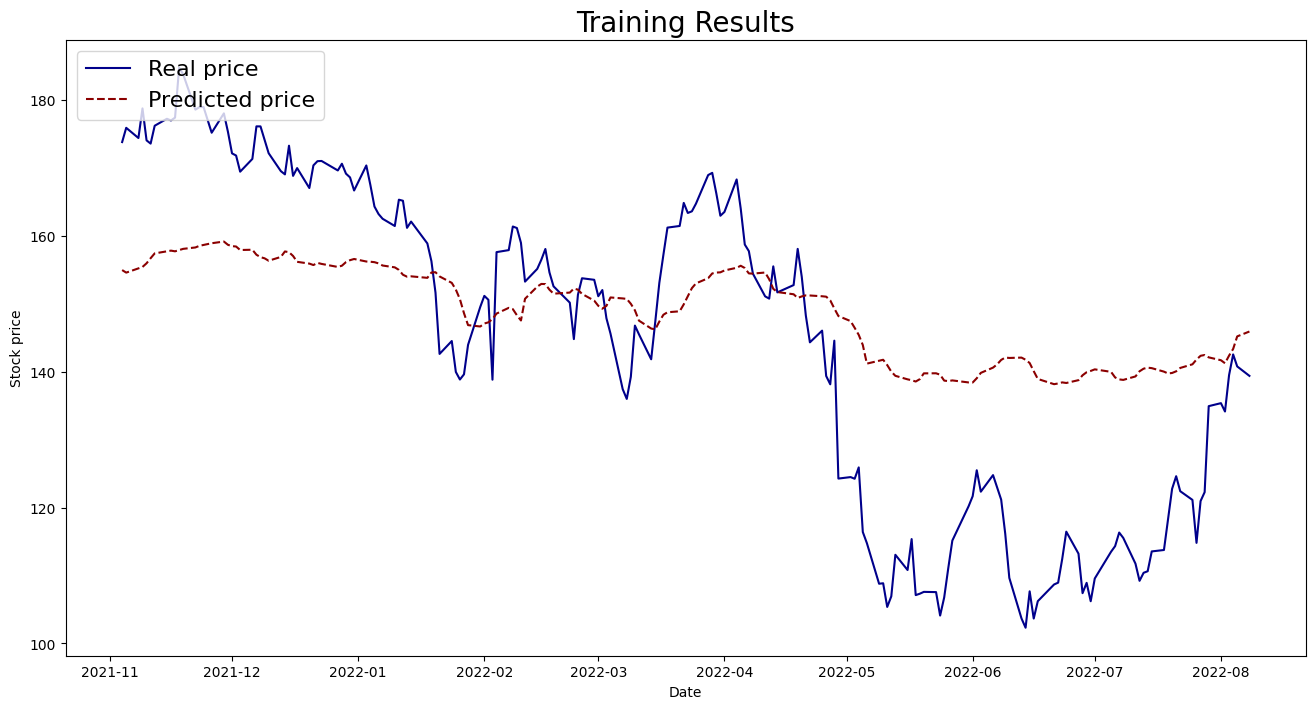

Train RMSE:  18.32602180097812
Test RMSE:  17.058588831445014
2022-08-09    146.364792
2022-08-10    147.148331
2022-08-11    147.694016
2022-08-12    147.556122
2022-08-15    147.437454
2022-08-16    147.457626
2022-08-17    148.026001
2022-08-18    148.091614
2022-08-19    148.250244
2022-08-22    148.465866
2022-08-23    148.126266
2022-08-24    147.687637
2022-08-25    147.458298
2022-08-26    146.322388
2022-08-29    145.681458
2022-08-30    145.818497
2022-08-31    145.765137
2022-09-01    145.651077
2022-09-02    144.856659
2022-09-06    144.361725
2022-09-07    144.144806
2022-09-08    143.971298
2022-09-09    143.638550
2022-09-12    143.805328
2022-09-13    143.913406
2022-09-14    144.213776
2022-09-15    144.697281
2022-09-16    145.180389
2022-09-19    144.766479
2022-09-20    143.607346
2022-09-21    143.365448
2022-09-22    142.813797
2022-09-23    142.184021
2022-09-26    142.438492
2022-09-27    141.882965
2022-09-28    141.239182
2022-09-29    140.816071
Name: predict

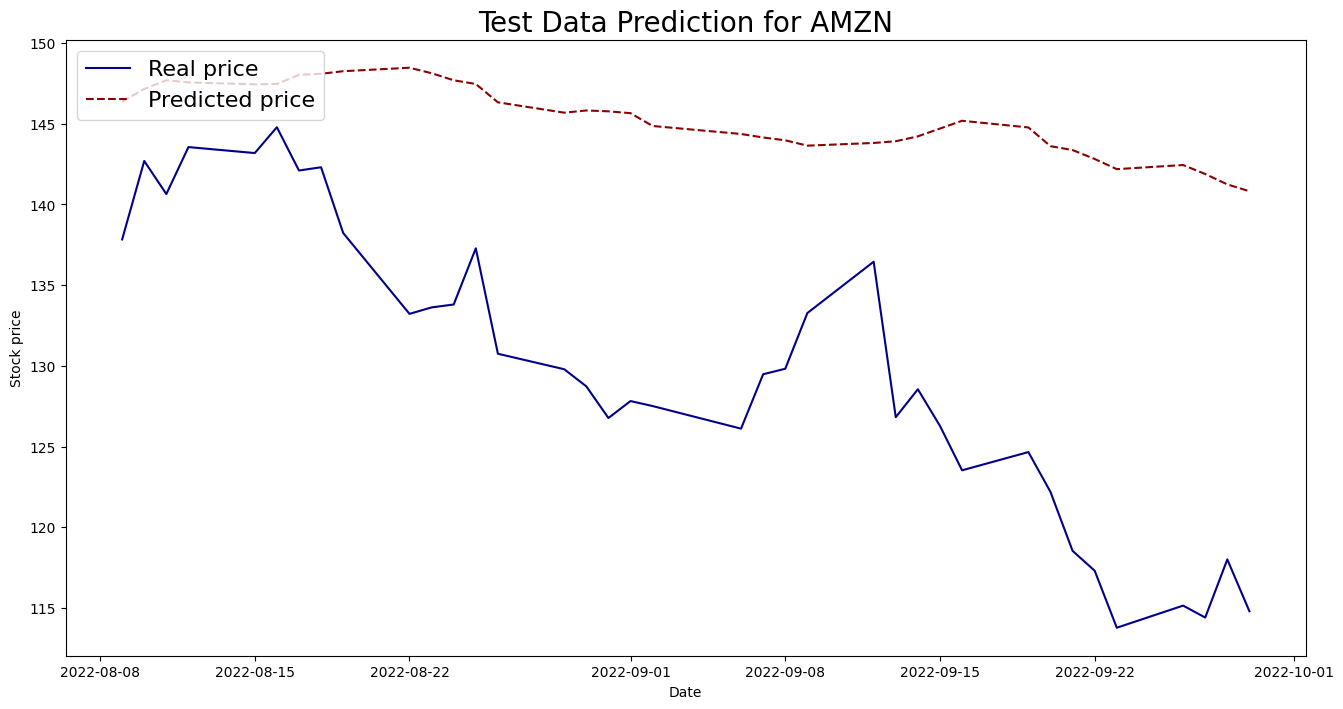

Train RMSE for fold 5: 0.44430491189736404
Test RMSE for fold 5: 0.4135766305780389
Average Train RMSE: 0.3935028447509832
Average Test RMSE: 0.46601613941827813


In [443]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)

train_rmse_list = []
test_rmse_list = []

for fold, (train_index, test_index) in enumerate(tscv.split(X_batched)):
    print(f"Fold {fold + 1}/{n_splits}")
    X_train_fold, X_test_fold = X_batched[train_index], X_batched[test_index]
    y_train_fold, y_test_fold = y_batched[train_index], y_batched[test_index]
    yc_train_fold, yc_test_fold = yc[train_index], yc[test_index]
    index_train_fold, index_test_fold = predict_index(dataset, X_train_fold, batch_size=5, prediction_period=1)

    # Train model with early stopping
    model, history = train_model(X_train_fold, y_train_fold, epochs=50, callbacks=[early_stopping])

    # Predict on training data
    train_predictions = model.predict(X_train_fold)
    train_rmse = np.sqrt(mean_squared_error(y_train_fold, train_predictions))
    train_rmse_list.append(train_rmse)

    # Predict on test data
    test_predictions = model.predict(X_test_fold)
    test_rmse = np.sqrt(mean_squared_error(y_test_fold, test_predictions))
    test_rmse_list.append(test_rmse)

    # Plot results for this fold
    plot_results(y_train_fold, train_predictions, index_train_fold)
    plot_test_data(y_test_fold, test_predictions, index_test_fold)

    print(f"Train RMSE for fold {fold + 1}: {train_rmse}")
    print(f"Test RMSE for fold {fold + 1}: {test_rmse}")

print(f"Average Train RMSE: {np.mean(train_rmse_list)}")
print(f"Average Test RMSE: {np.mean(test_rmse_list)}")


# TF-IDF, Technical Indicators and GAN Model

In [444]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as stat
import warnings
warnings.filterwarnings("ignore")

In [445]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [446]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [447]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [448]:
file_path = r'/content/drive/MyDrive/stock_tweets.csv'
train = pd.read_csv(file_path)
train.head()

Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.

In [449]:
file_path = r'/content/drive/MyDrive/stock_tweets.csv'
dataset = pd.read_csv(file_path)
dataset.head()

Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.

In [450]:
train = train[train['Stock Name'] == 'AMZN']

In [451]:
dataset = dataset[dataset['Stock Name'] == 'AMZN']

Handling User Mentions and Hashtags:

In [452]:
import re

# Define functions to extract user mentions and hashtags
def extract_user_mentions(text):
    # Use regex to find user mentions (e.g., @username)
    user_mentions = re.findall(r'@(\w+)', text)
    return user_mentions

def extract_hashtags(text):
    # Use regex to find hashtags (e.g., #topic)
    hashtags = re.findall(r'#(\w+)', text)
    return hashtags

# Apply the functions to the 'body' column
train['user_mentions'] = train['Tweet'].apply(extract_user_mentions)
train['hashtags'] = train['Tweet'].apply(extract_hashtags)

In [453]:
train.head()

Date  \
48351  2022-09-29 22:40:47+00:00   
48352  2022-09-29 22:23:54+00:00   
48353  2022-09-29 18:34:51+00:00   
48354  2022-09-29 15:57:59+00:00   
48355  2022-09-29 15:10:30+00:00   

                                                   Tweet Stock Name  \
48351  A group of lawmakers led by Sen. Elizabeth War...       AMZN   
48352  $NIO just because I'm down money doesn't mean ...       AMZN   
48353  Today’s drop in $SPX is a perfect example of w...       AMZN   
48354  Druckenmiller owned $CVNA this year \nMunger b...       AMZN   
48355  Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...       AMZN   

           Company Name user_mentions hashtags  
48351  Amazon.com, Inc.            []       []  
48352  Amazon.com, Inc.            []       []  
48353  Amazon.com, Inc.            []       []  
48354  Amazon.com, Inc.            []       []  
48355  Amazon.com, Inc.            []       []

Lower Case:

In [454]:
train['Tweet'] = train['Tweet'].str.lower()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4089 entries, 48351 to 52439
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           4089 non-null   object
 1   Tweet          4089 non-null   object
 2   Stock Name     4089 non-null   object
 3   Company Name   4089 non-null   object
 4   user_mentions  4089 non-null   object
 5   hashtags       4089 non-null   object
dtypes: object(6)
memory usage: 352.7+ KB


In [455]:
train.sample(10)

Date  \
48607  2022-08-22 01:00:23+00:00   
48442  2022-09-16 14:05:22+00:00   
50775  2022-02-18 21:09:29+00:00   
49207  2022-06-30 01:29:20+00:00   
52119  2021-11-06 04:24:40+00:00   
51265  2022-02-03 02:03:58+00:00   
48652  2022-08-16 03:42:58+00:00   
50122  2022-04-26 18:59:10+00:00   
52249  2021-10-28 16:21:27+00:00   
51323  2022-02-01 01:45:39+00:00   

                                                   Tweet Stock Name  \
48607  elite options #watchlist 💡\n\n📉 $amzn 136p &lt...       AMZN   
48442  i don't think the $fdx problem is only "macro"...       AMZN   
50775  at least we have a long weekend 😊\n\n⬇️ $se $r...       AMZN   
49207  $amzn is forming a head &amp; shoulders. if am...       AMZN   
52119  weekly highlights - option winners🏆🥳\n\n$nvda ...       AMZN   
51265  regardless of er numbies tomorrow \n\n $amzn i...       AMZN   
48652  top 5 buys of hedge funds in q2 2022.\n\nrecur...       AMZN   
50122  amazon $amzn surpassed walmart $wmt as the us’...       AMZN   
52249  icymi: mkt call with @riskreversal &amp; @cart...       AMZN   
51323  how many of you are interested in stocks? i ju...       AMZN   

           Company Name                                   user_mentions  \
48607  Amazon.com, Inc.                                              []   
48442  Amazon.com, Inc.                                              []   
50775  Amazon.com, Inc.                                              []   
49207  Amazon.com, Inc.                                              []   
52119  Amazon.com, Inc.                                              []   
51265  Amazon.com, Inc.                                              []   
48652  Amazon.com, Inc.                                              []   
50122  Amazon.com, Inc.                                              []   
52249  Amazon.com, Inc.  [RiskReversal, CarterBWorth, FactSet, openexc]   
51323  Amazon.com, Inc.                                              []   

          hashtags  
48607  [Watchlist]  
48442           []  
50775           []  
49207           []  
52119           []  
51265           []  
48652           []  
50122           []  
52249           []  
51323           []

Removing punctuations, special characters, URLs:

In [456]:
# Define a function to remove punctuation from a text string
def remove_punctuation(text):
    # Use regex to remove all non-alphanumeric characters (including punctuation)
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply the function to the 'text' column
train['Tweet'] = train['Tweet'].apply(remove_punctuation)

train.sample(10)

Date  \
49146  2022-07-08 12:14:35+00:00   
52424  2021-10-02 15:03:25+00:00   
51001  2022-02-04 11:16:43+00:00   
50622  2022-03-09 21:48:25+00:00   
49861  2022-05-02 19:11:23+00:00   
49436  2022-06-03 20:05:42+00:00   
51236  2022-02-03 16:13:23+00:00   
50430  2022-03-29 00:15:01+00:00   
51805  2021-12-16 00:49:46+00:00   
50612  2022-03-09 21:53:00+00:00   

                                                   Tweet Stock Name  \
49146  four of the six megacap tech names have moved ...       AMZN   
52424  meli killing it in brazil ecommerce amzn  se  ...       AMZN   
51001  happy flippin floki friday \n\nfloki just flip...       AMZN   
50622  while youre rushing to buy amzn for absolutely...       AMZN   
49861  decided to release the plan early in light of ...       AMZN   
49436  congrats everyone this was the last time you w...       AMZN   
51236  amazon will soon give 100 of its revenue to am...       AMZN   
50430  trade plan for tuesday \n\nspx if it holds 454...       AMZN   
51805  thursdays  list amd amzn burl fb se uvxy good ...       AMZN   
50612                               i swung amzn calls         AMZN   

           Company Name   user_mentions                hashtags  
49146  Amazon.com, Inc.              []                      []  
52424  Amazon.com, Inc.              []                      []  
51001  Amazon.com, Inc.  [RealFlokiInu]  [FLOKI, 1, Stocktwits]  
50622  Amazon.com, Inc.              []                      []  
49861  Amazon.com, Inc.              []                      []  
49436  Amazon.com, Inc.              []                      []  
51236  Amazon.com, Inc.              []                      []  
50430  Amazon.com, Inc.              []                      []  
51805  Amazon.com, Inc.              []                      []  
50612  Amazon.com, Inc.              []                      []

In [457]:
def remove_special_characters(text):
    # Use regex to remove all non-alphanumeric characters (including special characters)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

train['Tweet'] = train['Tweet'].apply(remove_special_characters)
train.sample(10)

Date  \
51169  2022-02-03 21:04:27+00:00   
48564  2022-08-26 12:34:51+00:00   
50510  2022-03-17 02:43:52+00:00   
48872  2022-07-28 20:20:25+00:00   
51661  2022-01-01 18:16:22+00:00   
49680  2022-05-15 21:10:57+00:00   
51573  2022-01-10 12:10:27+00:00   
50192  2022-04-22 17:57:49+00:00   
51443  2022-01-23 01:09:02+00:00   
49514  2022-05-29 13:46:29+00:00   

                                                   Tweet Stock Name  \
51169  earnings httpstcojewuqg959u q4 eps 2775 q4 rev...       AMZN   
48564  amazon amzn not expected to make bid for ea pe...       AMZN   
50510  tomorrow we watching amzn googl aapl high prio...       AMZN   
48872  cloud results vs estimates very strong conside...       AMZN   
51661  gartner expects enterprise data to grow at a 3...       AMZN   
49680  amzn weekly bounce at prior supply now acting ...       AMZN   
51573  amzn we estimate that aws advertising and 3p c...       AMZN   
50192  aapl 140s googl 2100s amzn 2500s and fb 160s a...       AMZN   
51443  looking at these analyst estimates amzn at cur...       AMZN   
49514  tsla gt amzn profits amp cash flow\n\ntsla  10...       AMZN   

           Company Name user_mentions hashtags  
51169  Amazon.com, Inc.            []       []  
48564  Amazon.com, Inc.            []       []  
50510  Amazon.com, Inc.            []       []  
48872  Amazon.com, Inc.            []       []  
51661  Amazon.com, Inc.            []       []  
49680  Amazon.com, Inc.            []       []  
51573  Amazon.com, Inc.            []       []  
50192  Amazon.com, Inc.            []       []  
51443  Amazon.com, Inc.            []       []  
49514  Amazon.com, Inc.            []       []

In [458]:
def remove_urls(text):
    # Use regex to remove URLs from the text
    text = re.sub(r'http\S+|www.\S+', '', text)
    return text

train['Tweet'] = train['Tweet'].apply(remove_urls)
train.sample(10)

Date  \
51086  2022-02-03 21:56:36+00:00   
50234  2022-04-20 00:55:21+00:00   
50623  2022-03-09 21:46:52+00:00   
49880  2022-05-01 19:17:41+00:00   
50850  2022-02-11 17:20:15+00:00   
49773  2022-05-09 20:02:54+00:00   
51765  2021-12-21 21:04:21+00:00   
52177  2021-10-30 11:39:05+00:00   
51592  2022-01-07 19:29:54+00:00   
50302  2022-04-13 12:21:00+00:00   

                                                   Tweet Stock Name  \
51086  holy snap back sad thing about holding a stock...       AMZN   
50234  heres the intro of todays marketoutlook video ...       AMZN   
50623          amzn 10b buyback  201 stock split \n\nwow       AMZN   
49880  maybe tomorrow opens limit down i dont know\n\...       AMZN   
50850  bill nygren talks nflx fb amzn aapl  msft chtr...       AMZN   
49773  on the bright side things are getting downrigh...       AMZN   
51765  that deserves some  \n\nits ok to celebrate th...       AMZN   
52177  and to review the top ten 72 of port positions...       AMZN   
51592  when amzn stock dips do investors forget about...       AMZN   
50302  groupm expects ctv advertising to continue to ...       AMZN   

           Company Name     user_mentions         hashtags  
51086  Amazon.com, Inc.                []               []  
50234  Amazon.com, Inc.  [MarketScholars]  [MarketOutlook]  
50623  Amazon.com, Inc.                []               []  
49880  Amazon.com, Inc.                []               []  
50850  Amazon.com, Inc.                []               []  
49773  Amazon.com, Inc.                []               []  
51765  Amazon.com, Inc.                []               []  
52177  Amazon.com, Inc.                []               []  
51592  Amazon.com, Inc.                []           [DeFi]  
50302  Amazon.com, Inc.                []               []

Tokenization

In [459]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [460]:
from nltk.tokenize import word_tokenize
train['tweet_tokens'] = train['Tweet'].apply(word_tokenize)
train.sample(5)

Date  \
50866  2022-02-09 14:47:37+00:00   
51834  2021-12-11 02:07:52+00:00   
50005  2022-04-28 22:11:52+00:00   
51942  2021-11-25 18:29:24+00:00   
52223  2021-10-28 20:43:47+00:00   

                                                   Tweet Stock Name  \
50866  with that being said\n\nrealizing 1017896 on 2...       AMZN   
51834  the results lottofriday \n\namzn 3450p  117 to...       AMZN   
50005  amzn takeaways 1 mgmt not expressing any conce...       AMZN   
51942  i used to speak regularly by email with a famo...       AMZN   
52223  as one megacap after another misses ests and g...       AMZN   

           Company Name user_mentions       hashtags  \
50866  Amazon.com, Inc.            []             []   
51834  Amazon.com, Inc.            []  [LottoFriday]   
50005  Amazon.com, Inc.            []             []   
51942  Amazon.com, Inc.            []             []   
52223  Amazon.com, Inc.            []             []   

                                            tweet_tokens  
50866  [with, that, being, said, realizing, 1017896, ...  
51834  [the, results, lottofriday, amzn, 3450p, 117, ...  
50005  [amzn, takeaways, 1, mgmt, not, expressing, an...  
51942  [i, used, to, speak, regularly, by, email, wit...  
52223  [as, one, megacap, after, another, misses, est...

Removing gibberish, stop words

In [461]:
from nltk.corpus import words

nltk.download('words')
english_words = set(words.words())

def remove_gibberish(tokens):
    cleaned_tokens = [token for token in tokens if token.lower() in english_words]
    return cleaned_tokens

train['tweet_tokens'] = train['tweet_tokens'].apply(remove_gibberish)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [462]:
nltk.download('all')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

train['tweet_tokens'] = train['tweet_tokens'].apply(remove_stopwords)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

In [463]:
train.sample(5)

Date  \
52018  2021-11-18 13:21:49+00:00   
52338  2021-10-18 11:59:30+00:00   
49097  2022-07-12 22:14:01+00:00   
51940  2021-11-25 19:16:30+00:00   
48912  2022-07-28 18:00:04+00:00   

                                                   Tweet Stock Name  \
52018  free daily picks  \n\nhappy trading\namp60 lik...       AMZN   
52338  the analysts consistently get this wrong the p...       AMZN   
49097  713 watchlist \n\ngoogl 2350c gt 230250  2220p...       AMZN   
51940  great wealth is not about technical analysis o...       AMZN   
48912  if aapl and amzn dont impress a lot of this co...       AMZN   

           Company Name   user_mentions hashtags  \
52018  Amazon.com, Inc.              []       []   
52338  Amazon.com, Inc.  [ASacconaghi1]       []   
49097  Amazon.com, Inc.              []       []   
51940  Amazon.com, Inc.              []       []   
48912  Amazon.com, Inc.              []       []   

                                            tweet_tokens  
52018  [free, daily, happy, trading, ba, spy, shop, c...  
52338  [consistently, get, wrong, proper, comparison,...  
49097                                               [ba]  
51940  [great, wealth, technical, analysis, stocks, n...  
48912  [dont, impress, lot, could, reversed, caution,...

Lemmatization

In [464]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 96.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [465]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [466]:
def lemmatize_tokens(tokens):
    text = " ".join(tokens)
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return lemmas

In [467]:
train['lemmatized_tweets'] = train['tweet_tokens'].apply(lemmatize_tokens)
train.sample(5)

Date  \
52166  2021-10-31 22:11:34+00:00   
49106  2022-07-12 01:29:03+00:00   
49061  2022-07-18 15:18:03+00:00   
48735  2022-08-05 22:32:32+00:00   
52410  2021-10-05 00:30:00+00:00   

                                                   Tweet Stock Name  \
52166  amzn\n\nlooking very similar to nflx before th...       AMZN   
49106  free options ideas \n\nscale out when above 25...       AMZN   
49061  its pretty incredible to me how emotional so m...       AMZN   
48735  amzn just purchased irbt irobot roomba for 1x ...       AMZN   
52410  most mentioned tickers on wsb via swaggy stock...       AMZN   

           Company Name user_mentions   hashtags  \
52166  Amazon.com, Inc.            []         []   
49106  Amazon.com, Inc.            []  [OPTIONS]   
49061  Amazon.com, Inc.            []         []   
48735  Amazon.com, Inc.            []         []   
52410  Amazon.com, Inc.            []         []   

                                            tweet_tokens  \
52166  [looking, similar, big, monthly, breakout, fin...   
49106  [free, scale, profit, crushed, today, massive,...   
49061  [pretty, incredible, emotional, many, say, som...   
48735  [revenue, bad, price, tag, company, increase, ...   
52410                  [via, swaggy, stocks, wish, baba]   

                                       lemmatized_tweets  
52166   [look, similar, big, monthly, breakout, finally]  
49106  [free, scale, profit, crush, today, massive, d...  
49061  [pretty, incredible, emotional, many, say, som...  
48735  [revenue, bad, price, tag, company, increase, ...  
52410                   [via, swaggy, stock, wish, baba]

N-Grams

In [468]:
from nltk.util import ngrams

In [469]:
n_gram_order = 2

def extract_ngrams(tokens, n):
    if len(tokens) >= n:
        return list(ngrams(tokens, n))
    else:
        return []

In [470]:
train['bigrams'] = train['lemmatized_tweets'].apply(lambda x: extract_ngrams(x, n_gram_order))
train.sample(10)

Date  \
49178  2022-07-04 15:00:54+00:00   
50320  2022-04-11 14:05:00+00:00   
49528  2022-05-27 20:10:10+00:00   
48703  2022-08-10 12:20:40+00:00   
49288  2022-06-16 01:58:46+00:00   
50323  2022-04-11 12:50:12+00:00   
51371  2022-01-28 05:03:14+00:00   
51173  2022-02-03 21:04:02+00:00   
51215  2022-02-03 18:50:14+00:00   
51711  2021-12-28 06:14:19+00:00   

                                                   Tweet Stock Name  \
49178  amzn of 1999 with bitcoin today there is an 80...       AMZN   
50320  great inflation hedge from amzn borrowing bill...       AMZN   
49528  nice finish \n\nno moves just enjoying a coupl...       AMZN   
48703  walmart wmt is building a streaming service to...       AMZN   
49288  best in class after your feedback\n\nsemicondu...       AMZN   
50323                 amzn files for 7part debt offering       AMZN   
51371           how i made 107k day trading amzn  12722        AMZN   
51173  amzn amazon to raise prime membership price to...       AMZN   
51215  might take a lotto into the closemight just wa...       AMZN   
51711  aapl has overtaken amzn as the second most act...       AMZN   

           Company Name user_mentions   hashtags  \
49178  Amazon.com, Inc.            []  [bitcoin]   
50320  Amazon.com, Inc.            []         []   
49528  Amazon.com, Inc.            []         []   
48703  Amazon.com, Inc.            []         []   
49288  Amazon.com, Inc.            []         []   
50323  Amazon.com, Inc.            []         []   
51371  Amazon.com, Inc.            []         []   
51173  Amazon.com, Inc.            []         []   
51215  Amazon.com, Inc.            []         []   
51711  Amazon.com, Inc.            []         []   

                                            tweet_tokens  \
49178                                    [today, offset]   
50320       [great, inflation, hedge, borrowing, spread]   
49528  [nice, finish, enjoying, couple, green, days, ...   
48703  [building, streaming, service, take, prime, pe...   
49288  [best, class, feedback, shop, baba, streaming,...   
50323                                   [debt, offering]   
51371                               [made, day, trading]   
51173                  [raise, prime, membership, price]   
51215  [might, take, lotto, wait, till, lotto, market...   
51711                           [second, active, ticker]   

                                       lemmatized_tweets  \
49178                                    [today, offset]   
50320       [great, inflation, hedge, borrowing, spread]   
49528  [nice, finish, enjoy, couple, green, day, row,...   
48703  [build, streaming, service, take, prime, per, ...   
49288  [good, class, feedback, shop, baba, stream, di...   
50323                                   [debt, offering]   
51371                               [make, day, trading]   
51173                  [raise, prime, membership, price]   
51215  [might, take, lotto, wait, till, lotto, market...   
51711                           [second, active, ticker]   

                                                 bigrams  
49178                                  [(today, offset)]  
50320  [(great, inflation), (inflation, hedge), (hedg...  
49528  [(nice, finish), (finish, enjoy), (enjoy, coup...  
48703  [(build, streaming), (streaming, service), (se...  
49288  [(good, class), (class, feedback), (feedback, ...  
50323                                 [(debt, offering)]  
51371                      [(make, day), (day, trading)]  
51173  [(raise, prime), (prime, membership), (members...  
51215  [(might, take), (take, lotto), (lotto, wait), ...  
51711               [(second, active), (active, ticker)]

In [471]:
n_gram_order = 3

def extract_ngrams(tokens, n):
    if len(tokens) >= n:
        return list(ngrams(tokens, n))
    else:
        return []

In [472]:
train['trigrams'] = train['lemmatized_tweets'].apply(lambda x: extract_ngrams(x, n_gram_order))
train.head(10)

Date  \
48351  2022-09-29 22:40:47+00:00   
48352  2022-09-29 22:23:54+00:00   
48353  2022-09-29 18:34:51+00:00   
48354  2022-09-29 15:57:59+00:00   
48355  2022-09-29 15:10:30+00:00   
48356  2022-09-29 13:38:47+00:00   
48357  2022-09-29 13:04:39+00:00   
48358  2022-09-29 10:18:43+00:00   
48359  2022-09-29 06:58:00+00:00   
48360  2022-09-29 00:14:54+00:00   

                                                   Tweet Stock Name  \
48351  a group of lawmakers led by sen elizabeth warr...       AMZN   
48352  nio just because im down money doesnt mean thi...       AMZN   
48353  todays drop in spx is a perfect example of wha...       AMZN   
48354  druckenmiller owned cvna this year \nmunger bo...       AMZN   
48355  top 10 qqq holdings \n\nand credit rating\n\na...       AMZN   
48356            wage inflation  profit margin \namzn\n        AMZN   
48357  amazon to loan over 150m to small businesses o...       AMZN   
48358  stocks i think entering intriguing levels to a...       AMZN   
48359   news\n\n boe buys bonds saves pensions\n mort...       AMZN   
48360  92922 options trading watchlist \n\namzn 11411...       AMZN   

           Company Name user_mentions                  hashtags  \
48351  Amazon.com, Inc.            []                        []   
48352  Amazon.com, Inc.            []                        []   
48353  Amazon.com, Inc.            []                        []   
48354  Amazon.com, Inc.            []                        []   
48355  Amazon.com, Inc.            []                        []   
48356  Amazon.com, Inc.            []                        []   
48357  Amazon.com, Inc.            []                        []   
48358  Amazon.com, Inc.            []                        []   
48359  Amazon.com, Inc.            []                        []   
48360  Amazon.com, Inc.            []  [optionstrading, stocks]   

                                            tweet_tokens  \
48351  [group, led, sen, warren, federal, trade, comm...   
48352  [money, doesnt, mean, bad, investment, whole, ...   
48353  [drop, perfect, example, turn, lower, finally,...   
48354  [year, bought, baba, margin, dean, valuation, ...   
48355  [top, credit, rating, meta, pep, cost, coming,...   
48356                  [wage, inflation, profit, margin]   
48357                                [loan, small, next]   
48358  [stocks, think, entering, intriguing, add, sev...   
48359  [news, mortgage, leave, politician, stock, ban...   
48360  [trading, bearish, job, report, significant, c...   

                                       lemmatized_tweets  \
48351  [group, lead, sen, warren, federal, trade, com...   
48352  [money, do, not, mean, bad, investment, whole,...   
48353  [drop, perfect, example, turn, lower, finally,...   
48354  [year, buy, baba, margin, dean, valuation, met...   
48355  [top, credit, rating, meta, pep, cost, come, l...   
48356                  [wage, inflation, profit, margin]   
48357                                [loan, small, next]   
48358  [stock, think, enter, intriguing, add, several...   
48359  [news, mortgage, leave, politician, stock, ban...   
48360  [trade, bearish, job, report, significant, cha...   

                                                 bigrams  \
48351  [(group, lead), (lead, sen), (sen, warren), (w...   
48352  [(money, do), (do, not), (not, mean), (mean, b...   
48353  [(drop, perfect), (perfect, example), (example...   
48354  [(year, buy), (buy, baba), (baba, margin), (ma...   
48355  [(top, credit), (credit, rating), (rating, met...   
48356  [(wage, inflation), (inflation, profit), (prof...   
48357                     [(loan, small), (small, next)]   
48358  [(stock, think), (think, enter), (enter, intri...   
48359  [(news, mortgage), (mortgage, leave), (leave, ...   
48360  [(trade, bearish), (bearish, job), (job, repor...   

                                                trigrams  
48351  [(group, lead, sen), (lead, sen, warren), (sen...  
48352  [(m

TF-IDF

In [473]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [474]:
train['tfidf_text'] = train['lemmatized_tweets'].apply(lambda tokens: ' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(train['tfidf_text'])
tfidf_features = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_features)
tfidf_df.head()

aa  aal  ability  able  abortion  absent  absolute  absolutely  absurd  \
0  0.0  0.0      0.0   0.0       0.0     0.0       0.0         0.0     0.0   
1  0.0  0.0      0.0   0.0       0.0     0.0       0.0         0.0     0.0   
2  0.0  0.0      0.0   0.0       0.0     0.0       0.0         0.0     0.0   
3  0.0  0.0      0.0   0.0       0.0     0.0       0.0         0.0     0.0   
4  0.0  0.0      0.0   0.0       0.0     0.0       0.0         0.0     0.0   

   abundance  ...   yo  york  you  young  yoy   yr  zero  zipper  zone  zoom  
0        0.0  ...  0.0   0.0  0.0    0.0  0.0  0.0   0.0     0.0   0.0   0.0  
1        0.0  ...  0.0   0.0  0.0    0.0  0.0  0.0   0.0     0.0   0.0   0.0  
2        0.0  ...  0.0   0.0  0.0    0.0  0.0  0.0   0.0     0.0   0.0   0.0  
3        0.0  ...  0.0   0.0  0.0    0.0  0.0  0.0   0.0     0.0   0.0   0.0  
4        0.0  ...  0.0   0.0  0.0    0.0  0.0  0.0   0.0     0.0   0.0   0.0  

[5 rows x 3879 columns]

In [475]:
non_zero_count = np.count_nonzero(tfidf_df.values)
print("Number of non-zero values in tfidf_df:", non_zero_count)

Number of non-zero values in tfidf_df: 36447


In [476]:
train.head(10)

Date  \
48351  2022-09-29 22:40:47+00:00   
48352  2022-09-29 22:23:54+00:00   
48353  2022-09-29 18:34:51+00:00   
48354  2022-09-29 15:57:59+00:00   
48355  2022-09-29 15:10:30+00:00   
48356  2022-09-29 13:38:47+00:00   
48357  2022-09-29 13:04:39+00:00   
48358  2022-09-29 10:18:43+00:00   
48359  2022-09-29 06:58:00+00:00   
48360  2022-09-29 00:14:54+00:00   

                                                   Tweet Stock Name  \
48351  a group of lawmakers led by sen elizabeth warr...       AMZN   
48352  nio just because im down money doesnt mean thi...       AMZN   
48353  todays drop in spx is a perfect example of wha...       AMZN   
48354  druckenmiller owned cvna this year \nmunger bo...       AMZN   
48355  top 10 qqq holdings \n\nand credit rating\n\na...       AMZN   
48356            wage inflation  profit margin \namzn\n        AMZN   
48357  amazon to loan over 150m to small businesses o...       AMZN   
48358  stocks i think entering intriguing levels to a...       AMZN   
48359   news\n\n boe buys bonds saves pensions\n mort...       AMZN   
48360  92922 options trading watchlist \n\namzn 11411...       AMZN   

           Company Name user_mentions                  hashtags  \
48351  Amazon.com, Inc.            []                        []   
48352  Amazon.com, Inc.            []                        []   
48353  Amazon.com, Inc.            []                        []   
48354  Amazon.com, Inc.            []                        []   
48355  Amazon.com, Inc.            []                        []   
48356  Amazon.com, Inc.            []                        []   
48357  Amazon.com, Inc.            []                        []   
48358  Amazon.com, Inc.            []                        []   
48359  Amazon.com, Inc.            []                        []   
48360  Amazon.com, Inc.            []  [optionstrading, stocks]   

                                            tweet_tokens  \
48351  [group, led, sen, warren, federal, trade, comm...   
48352  [money, doesnt, mean, bad, investment, whole, ...   
48353  [drop, perfect, example, turn, lower, finally,...   
48354  [year, bought, baba, margin, dean, valuation, ...   
48355  [top, credit, rating, meta, pep, cost, coming,...   
48356                  [wage, inflation, profit, margin]   
48357                                [loan, small, next]   
48358  [stocks, think, entering, intriguing, add, sev...   
48359  [news, mortgage, leave, politician, stock, ban...   
48360  [trading, bearish, job, report, significant, c...   

                                       lemmatized_tweets  \
48351  [group, lead, sen, warren, federal, trade, com...   
48352  [money, do, not, mean, bad, investment, whole,...   
48353  [drop, perfect, example, turn, lower, finally,...   
48354  [year, buy, baba, margin, dean, valuation, met...   
48355  [top, credit, rating, meta, pep, cost, come, l...   
48356                  [wage, inflation, profit, margin]   
48357                                [loan, small, next]   
48358  [stock, think, enter, intriguing, add, several...   
48359  [news, mortgage, leave, politician, stock, ban...   
48360  [trade, bearish, job, report, significant, cha...   

                                                 bigrams  \
48351  [(group, lead), (lead, sen), (sen, warren), (w...   
48352  [(money, do), (do, not), (not, mean), (mean, b...   
48353  [(drop, perfect), (perfect, example), (example...   
48354  [(year, buy), (buy, baba), (baba, margin), (ma...   
48355  [(top, credit), (credit, rating), (rating, met...   
48356  [(wage, inflation), (inflation, profit), (prof...   
48357                     [(loan, small), (small, next)]   
48358  [(stock, think), (think, enter), (enter, intri...   
48359  [(news, mortgage), (mortgage, leave), (leave, ...   
48360  [(trade, bearish), (bearish, job), (job, repor...   

                                                trigrams  \
48351  [(group, lead, sen), (lead, sen, warren), (sen...   
48352  [

WordCloud

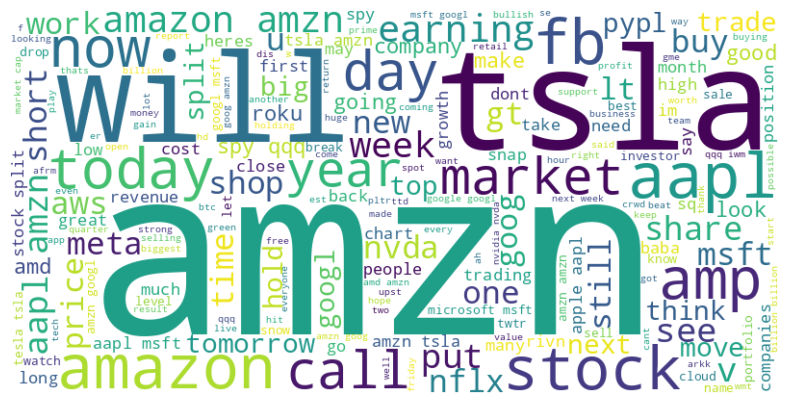

In [477]:
#Unigram cloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'tweet' column contains the text data
text_data = ' '.join(train['Tweet'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

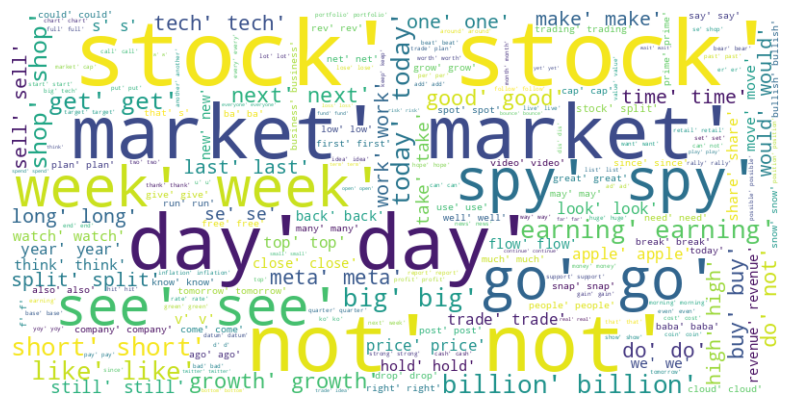

In [478]:
bigram_text = ' '.join([' '.join(map(str, bigrams)) for bigrams in train['bigrams']])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(bigram_text)

# Display the bigram word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#VADER Sentiment Analysis

In [479]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [480]:
def get_sentiment_scores(text):
    # Join the list of lemmatized words into a single string
    text = ' '.join(text)
    sentiment = analyzer.polarity_scores(text)
    return sentiment

train['sentiment_scores'] = train['lemmatized_tweets'].apply(get_sentiment_scores)
train['compound_score'] = train['sentiment_scores'].apply(lambda x: x['compound'])
train.sample(10)

Date  \
52421  2021-10-04 02:40:57+00:00   
50986  2022-02-04 13:53:38+00:00   
50932  2022-02-05 15:18:27+00:00   
49852  2022-05-03 12:17:56+00:00   
50922  2022-02-06 14:00:40+00:00   
49031  2022-07-21 13:59:12+00:00   
49288  2022-06-16 01:58:46+00:00   
48989  2022-07-24 18:37:56+00:00   
51796  2021-12-16 21:35:28+00:00   
50657  2022-03-08 01:52:46+00:00   

                                                   Tweet Stock Name  \
52421  1 shop 15 of port 2300 combined returns\n2 mel...       AMZN   
50986  amzn price target raised from 3800 to 4400 at ...       AMZN   
50932  microsofts market share of cloud spending is m...       AMZN   
49852  mega tech shorts update 2q 22\n\nshort aapl 94...       AMZN   
50922   9 tech charts courtesy of \ntrendspider\n\n i...       AMZN   
49031  the health space has seen some of the best act...       AMZN   
49288  best in class after your feedback\n\nsemicondu...       AMZN   
48989  most anticipated releases for the week beginni...       AMZN   
51796  amzn stk at 3309 you buy 3350 calls at 1 you b...       AMZN   
50657  turn around tuesday triggers \n\n coin 170c gt...       AMZN   

           Company Name  user_mentions hashtags  \
52421  Amazon.com, Inc.             []       []   
50986  Amazon.com, Inc.             []       []   
50932  Amazon.com, Inc.             []       []   
49852  Amazon.com, Inc.             []       []   
50922  Amazon.com, Inc.  [trendspider]       []   
49031  Amazon.com, Inc.             []       []   
49288  Amazon.com, Inc.             []       []   
48989  Amazon.com, Inc.             []       []   
51796  Amazon.com, Inc.             []       []   
50657  Amazon.com, Inc.             []       []   

                                            tweet_tokens  \
52421  [shop, port, combined, se, axon, team, u, cont...   
50986                            [price, target, raised]   
50932  [market, share, cloud, spending, making, impre...   
49852  [tech, shorts, update, short, short, short, sh...   
50922  [tech, courtesy, ill, get, end, today, thread,...   
49031  [health, space, seen, best, action, noted, dai...   
49288  [best, class, feedback, shop, baba, streaming,...   
48989              [week, beginning, ba, ko, meta, shop]   
51796  [buy, buy, sam, dumb, ass, dont, know, open, t...   
50657                         [turn, around, coin, riot]   

                                       lemmatized_tweets  \
52421  [shop, port, combine, se, axon, team, u, conti...   
50986                             [price, target, raise]   
50932  [market, share, cloud, spending, make, impress...   
49852  [tech, short, update, short, short, short, sho...   
50922  [tech, courtesy, ill, get, end, today, thread,...   
49031  [health, space, see, good, action, note, daily...   
49288  [good, class, feedback, shop, baba, stream, di...   
48989                  [week, begin, ba, ko, meta, shop]   
51796  [buy, buy, sam, dumb, ass, do, not, know, open...   
50657                         [turn, around, coin, riot]   

                                                 bigrams  \
52421  [(shop, port), (port, combine), (combine, se),...   
50986                 [(price, target), (target, raise)]   
50932  [(market, share), (share, cloud), (cloud, spen...   
49852  [(tech, short), (short, update), (update, shor...   
50922  [(tech, courtesy), (courtesy, ill), (ill, get)...   
49031  [(health, space), (space, see), (see, good), (...   
49288  [(good, class), (class, feedback), (feedback, ...   
48989  [(week, begin), (begin, ba), (ba, ko), (ko, me...   
51796  [(buy, buy), (buy, sam), (sam, dumb), (dumb, a...   
50657     [(turn, around), (around, coin), (coin, riot)]   

                                                trigrams  \
52421  [(shop, port, combine), (port, combine, se), (...   
50986                           [(price, target, raise)]   
50932  [(market, share, cloud), (share, cloud, spendi...   
49852  [(tech, short, update), (short, update, short)...   
5092

#Stock prediction

In [481]:
# dataset.head()
train['tweets'] = dataset['Tweet']
train.head()

Date  \
48351  2022-09-29 22:40:47+00:00   
48352  2022-09-29 22:23:54+00:00   
48353  2022-09-29 18:34:51+00:00   
48354  2022-09-29 15:57:59+00:00   
48355  2022-09-29 15:10:30+00:00   

                                                   Tweet Stock Name  \
48351  a group of lawmakers led by sen elizabeth warr...       AMZN   
48352  nio just because im down money doesnt mean thi...       AMZN   
48353  todays drop in spx is a perfect example of wha...       AMZN   
48354  druckenmiller owned cvna this year \nmunger bo...       AMZN   
48355  top 10 qqq holdings \n\nand credit rating\n\na...       AMZN   

           Company Name user_mentions hashtags  \
48351  Amazon.com, Inc.            []       []   
48352  Amazon.com, Inc.            []       []   
48353  Amazon.com, Inc.            []       []   
48354  Amazon.com, Inc.            []       []   
48355  Amazon.com, Inc.            []       []   

                                            tweet_tokens  \
48351  [group, led, sen, warren, federal, trade, comm...   
48352  [money, doesnt, mean, bad, investment, whole, ...   
48353  [drop, perfect, example, turn, lower, finally,...   
48354  [year, bought, baba, margin, dean, valuation, ...   
48355  [top, credit, rating, meta, pep, cost, coming,...   

                                       lemmatized_tweets  \
48351  [group, lead, sen, warren, federal, trade, com...   
48352  [money, do, not, mean, bad, investment, whole,...   
48353  [drop, perfect, example, turn, lower, finally,...   
48354  [year, buy, baba, margin, dean, valuation, met...   
48355  [top, credit, rating, meta, pep, cost, come, l...   

                                                 bigrams  \
48351  [(group, lead), (lead, sen), (sen, warren), (w...   
48352  [(money, do), (do, not), (not, mean), (mean, b...   
48353  [(drop, perfect), (perfect, example), (example...   
48354  [(year, buy), (buy, baba), (baba, margin), (ma...   
48355  [(top, credit), (credit, rating), (rating, met...   

                                                trigrams  \
48351  [(group, lead, sen), (lead, sen, warren), (sen...   
48352  [(money, do, not), (do, not, mean), (not, mean...   
48353  [(drop, perfect, example), (perfect, example, ...   
48354  [(year, buy, baba), (buy, baba, margin), (baba...   
48355  [(top, credit, rating), (credit, rating, meta)...   

                                              tfidf_text  \
48351  group lead sen warren federal trade commission...   
48352  money do not mean bad investment whole market ...   
48353  drop perfect example turn lower finally drop b...   
48354  year buy baba margin dean valuation meta year ...   
48355  top credit rating meta pep cost come learn cre...   

                                        sentiment_scores  compound_score  \
48351  {'neg': 0.197, 'neu': 0.803, 'pos': 0.0, 'comp...         -0.4019   
48352  {'neg': 0.069, 'neu': 0.491, 'pos': 0.44, 'com...          0.8201   
48353  {'neg': 0.417, 'neu': 0.304, 'pos': 0.278, 'co...         -0.2960   
48354  {'neg': 0.0, 'neu': 0.873, 'pos': 0.127, 'comp...          0.4404   
48355  {'neg': 0.0, 'neu': 0.405, 'pos': 0.595, 'comp...          0.7783   

                                                  tweets  
48351  A group of lawmakers led by Sen. Elizabeth War...  
48352  $NIO just because I'm down money doesn't mean ...  
48353  Today’s drop in $SPX is a perfect example of w...  
48354  Druckenmiller owned $CVNA this year \nMunger b...  
48355  Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...

In [482]:
analyzer = SentimentIntensityAnalyzer()

# Define a function to get sentiment scores
def get_sentiment_scores(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment

# Apply sentiment analysis to the 'text' column and create new columns for sentiment scores
train['sentiment_scores'] = train['tweets'].apply(get_sentiment_scores)

# Extract the compound sentiment score
train['compound_score'] = train['sentiment_scores'].apply(lambda x: x['compound'])

In [483]:
stock_tweets = train[['Date','compound_score']]
stock_tweets.sample(10)

Date  compound_score
49347  2022-06-09 03:52:53+00:00          0.0000
49019  2022-07-22 05:51:56+00:00         -0.3382
48439  2022-09-16 19:37:10+00:00          0.8519
48796  2022-07-30 21:05:04+00:00          0.2960
50615  2022-03-09 21:51:57+00:00          0.4184
52254  2021-10-27 22:22:03+00:00          0.0000
48808  2022-07-29 20:23:59+00:00          0.1779
51538  2022-01-14 06:02:51+00:00          0.4493
48531  2022-09-01 22:01:47+00:00          0.9554
48987  2022-07-24 20:12:05+00:00         -0.0644

In [484]:
stock_tweets.shape

(4089, 2)

In [485]:
stock_tweets['Date'] = pd.to_datetime(stock_tweets['Date'])
stock_tweets['Date'] = stock_tweets['Date'].dt.date
stock_tweets.head()

Date  compound_score
48351  2022-09-29         -0.0772
48352  2022-09-29          0.2500
48353  2022-09-29         -0.3182
48354  2022-09-29          0.2382
48355  2022-09-29          0.7783

In [486]:
stock_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4089 entries, 48351 to 52439
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4089 non-null   object 
 1   compound_score  4089 non-null   float64
dtypes: float64(1), object(1)
memory usage: 224.9+ KB


In [487]:
twitter_df = stock_tweets.groupby([stock_tweets['Date']]).mean()
print(twitter_df.shape)
twitter_df.sample(10)

(365, 1)


compound_score
Date                      
2022-07-15        0.358400
2022-09-28        0.394520
2022-02-14        0.119675
2022-05-10        0.099136
2021-12-14       -0.037450
2021-12-24        0.178780
2022-03-22        0.294911
2022-08-22        0.147238
2021-11-22        0.457458
2022-07-08        0.350709

In [488]:
file_path = r'/content/drive/MyDrive/stock_yfinance_data.csv'
stocks = pd.read_csv(file_path)
stocks.head()

Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name  
0  53868000       TSLA  
1  51094200       TSLA  
2  91449900       TSLA  
3  55297800       TSLA  
4  43898400       TSLA

In [489]:
stock_name = 'AMZN'

stock_df = stocks[stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [490]:
final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

final_df.head()

(252, 8)


Date        Open        High         Low       Close   Adj Close  \
1008  2021-09-30  165.800003  166.392502  163.699493  164.251999  164.251999   
1009  2021-10-01  164.450500  165.458496  162.796997  164.162994  164.162994   
1010  2021-10-04  163.969498  163.999496  158.812500  159.488998  159.488998   
1011  2021-10-05  160.225006  163.036499  160.123001  161.050003  161.050003   
1012  2021-10-06  160.676498  163.216995  159.931000  163.100494  163.100494   

        Volume  compound_score  
1008  56848000        0.246480  
1009  56712000        0.359337  
1010  90462000        0.258650  
1011  65384000        0.045500  
1012  50660000        0.194300

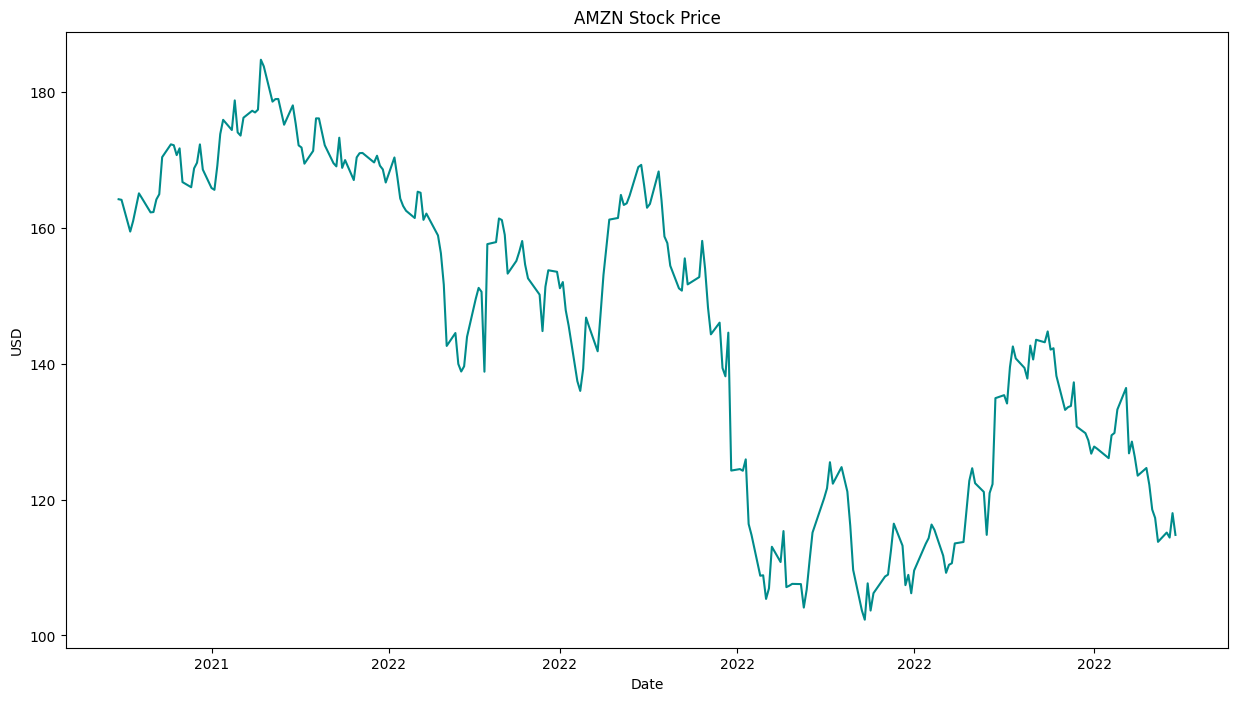

In [491]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter  # Import DateFormatter

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

#Adding technical indicators
MA(7) stans for Moving Average for past 7 days, whereas MA(20) means Moving Average for past 20 days.

EMA is Exponential Moving average and we can calculate it as:

EMA_t = Pclose + (EMA_t-1 (100 - P))* Bollinger Bands are calculated as:

middle line: stdev(MA(20)) upper bound: MA(20) + 2stdev(MA(20)) lower bound: MA(20) - 2stdev(MA(20))

In [492]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [493]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

Date        Open        High         Low       Close   Adj Close  \
0  2021-10-28  170.104996  173.949997  169.300003  172.328506  172.328506   
1  2021-10-29  165.001007  168.740997  163.666000  168.621506  168.621506   
2  2021-11-01  168.089996  168.792999  164.600998  165.905502  165.905502   
3  2021-11-02  165.750504  166.556000  164.177505  165.637497  165.637497   
4  2021-11-03  165.449997  169.746002  164.876007  169.199997  169.199997   

      Volume  compound_score         MA7        MA20      MACD      20SD  \
0  114174000       -0.001450  169.436571  166.614751 -0.644339  4.111286   
1  129722000        0.140447  169.132071  166.837676 -0.040452  4.092180   
2   72178000        0.369745  168.297071  167.158501 -0.243565  3.720357   
3   52552000        0.336614  168.134214  167.387876 -0.088001  3.455945   
4   67944000        0.260729  168.588715  167.692851  0.389213  3.324309   

   upper_band  lower_band         EMA  logmomentum  
0  174.837323  158.392179  171.261756     5.143583  
1  175.022037  158.653316  169.501589     5.121708  
2  174.599216  159.717786  167.104198     5.105373  
3  174.299767  160.475986  166.126397     5.103746  
4  174.341469  161.044234  168.175464     5.125154

In [494]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

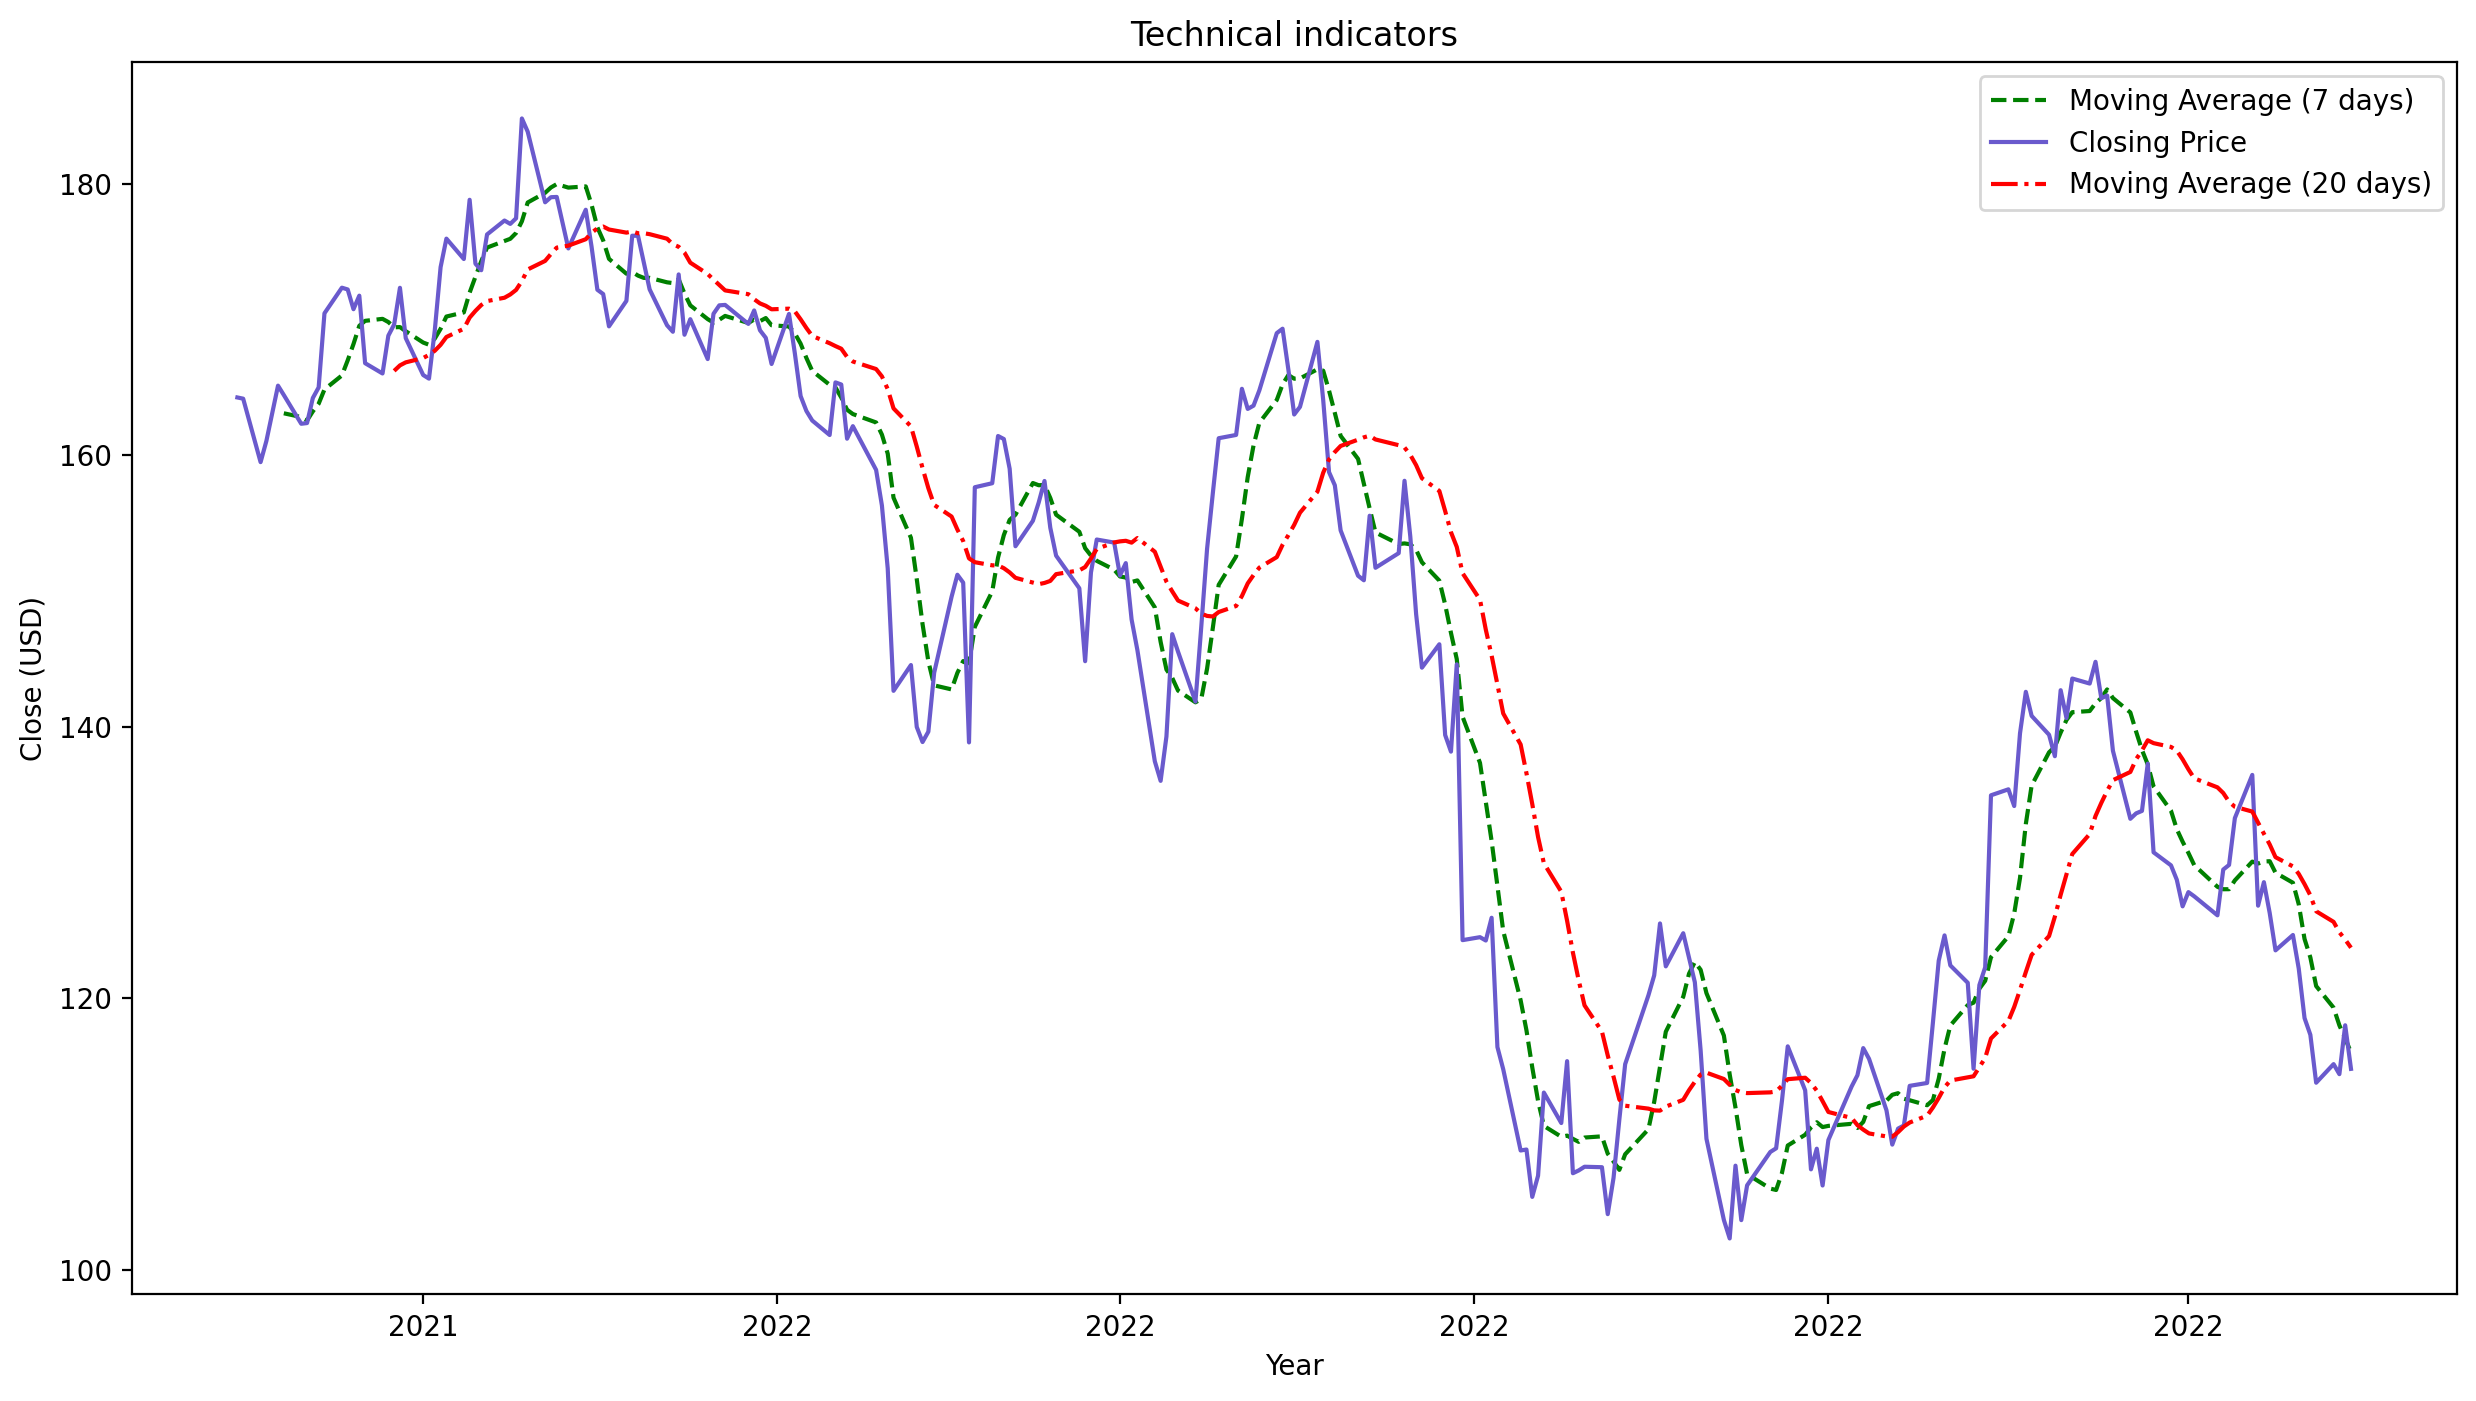

In [495]:
tech_ind(tech_df)

In [496]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [497]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [498]:
def normalize_data(df, range, target_column):

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [499]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [500]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [501]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [502]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata


In [503]:
from sklearn.preprocessing import MinMaxScaler
import pickle  # Import the pickle module

X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 15)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [504]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

In [505]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True,
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

In [506]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    #cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [507]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [508]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [509]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())


        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())

        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)

    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [510]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

In [511]:
## Test Code

@tf.function

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [512]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
    plt.show()

In [513]:
learning_rate = 5e-4
epochs = 50

g_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])

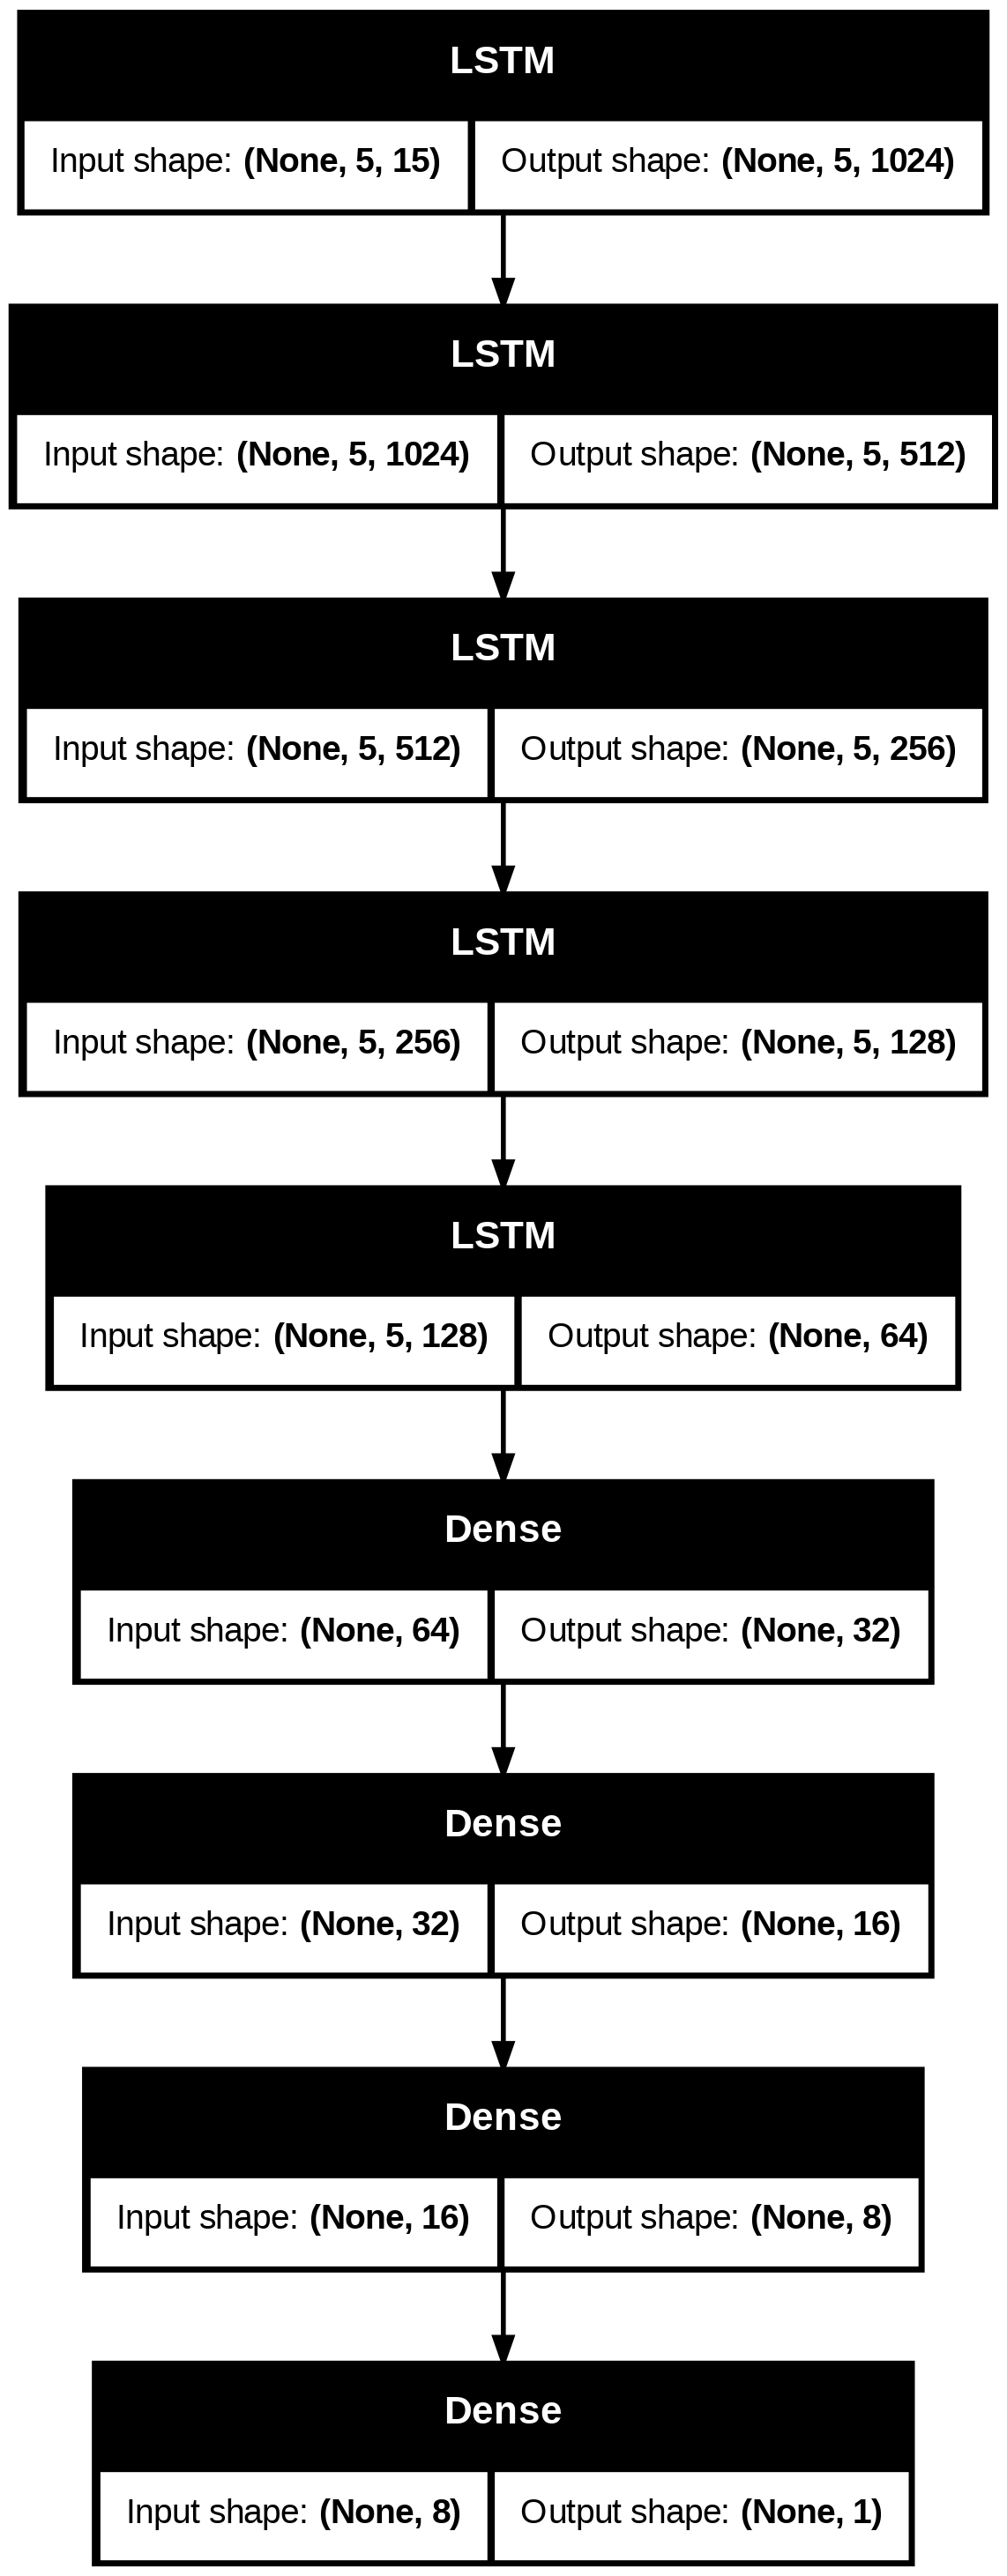

In [514]:
plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)

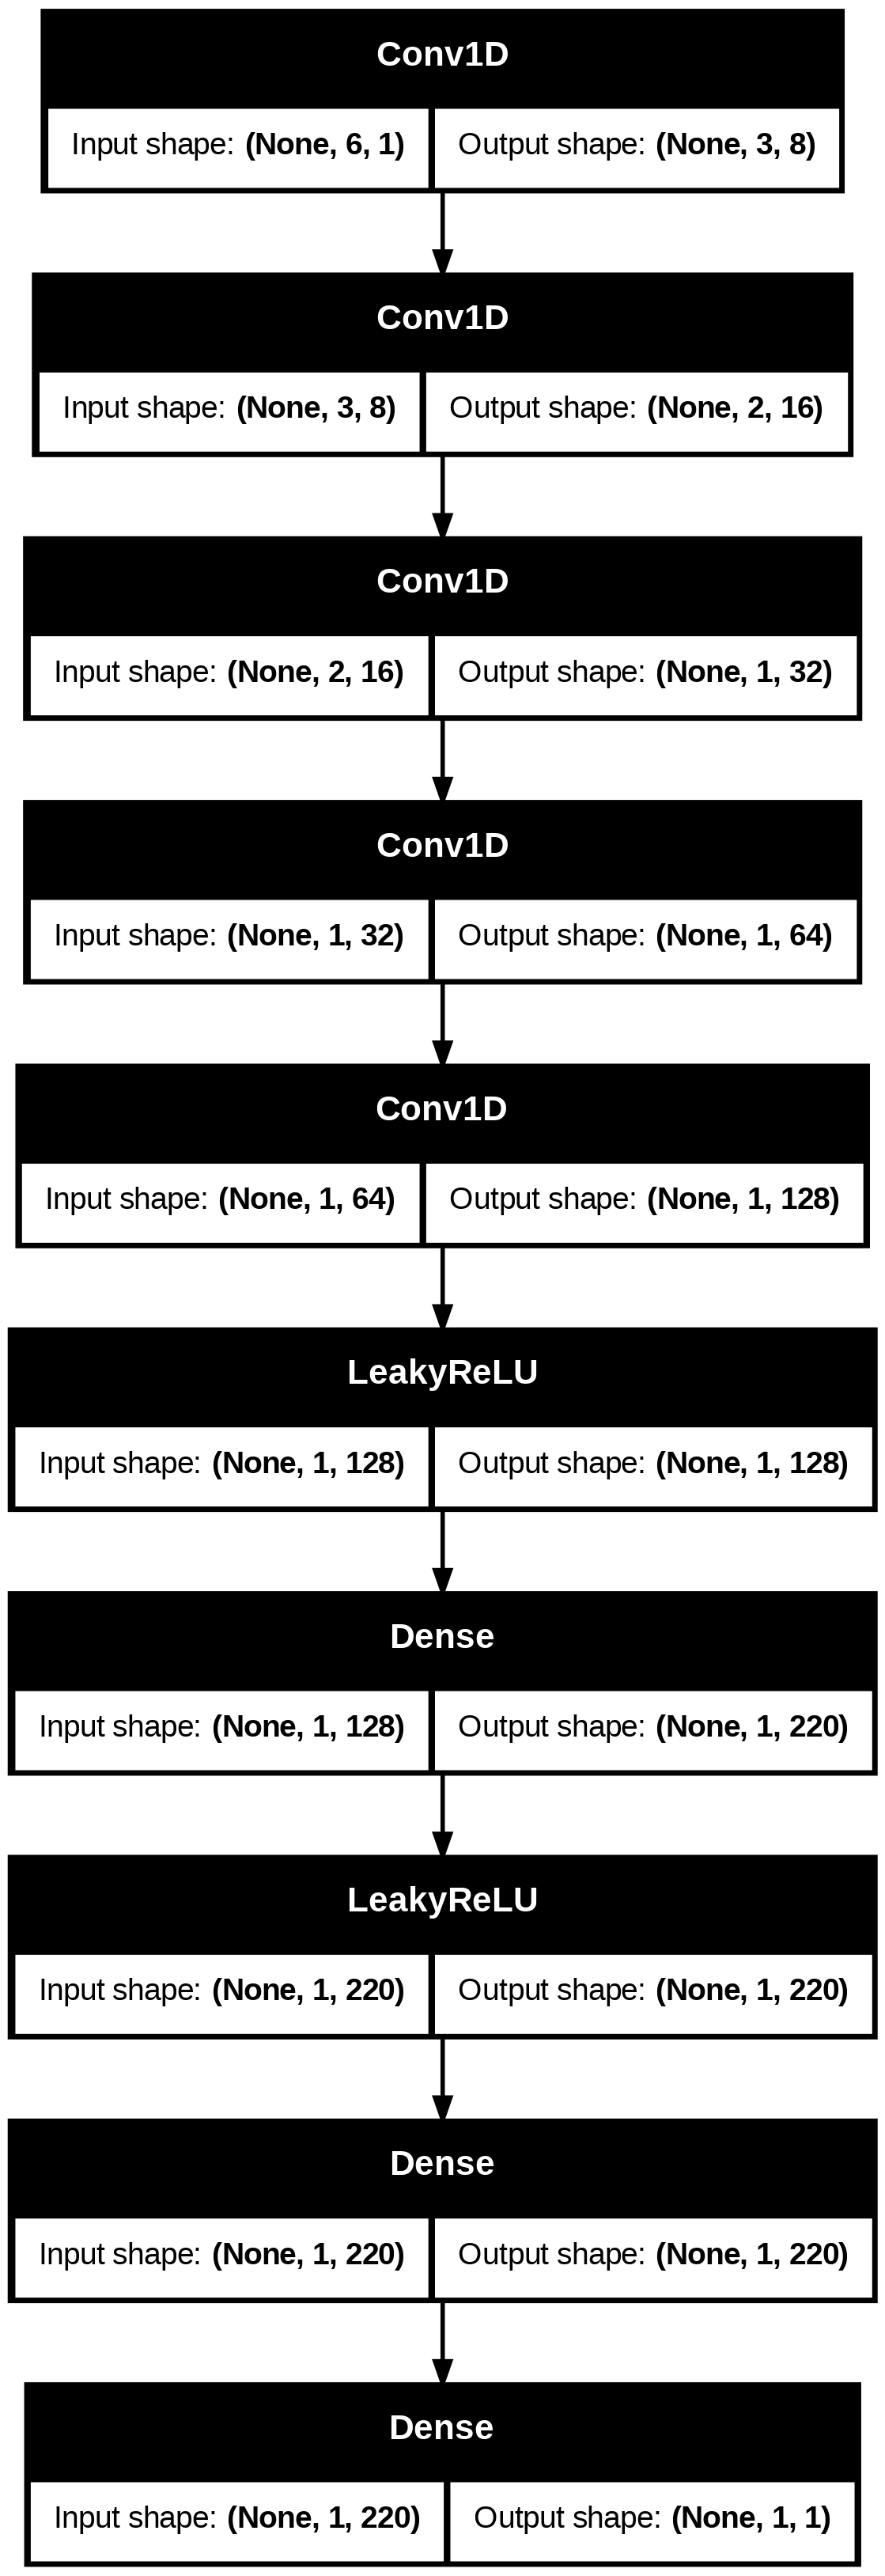

In [515]:
tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)

100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


epoch 50 discriminator_loss 1.4470985 generator_loss 0.6600819


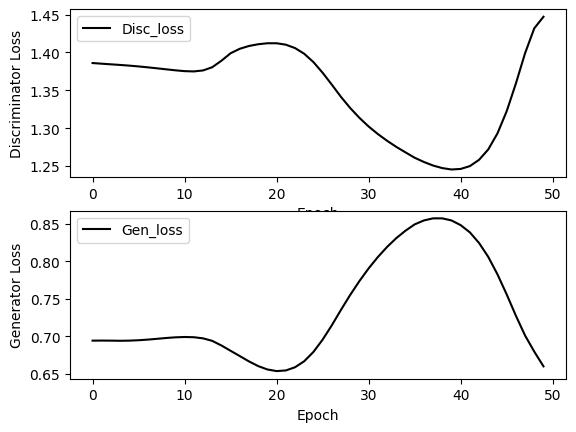

In [516]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [517]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')

Test RMSE:  22.205769664862085


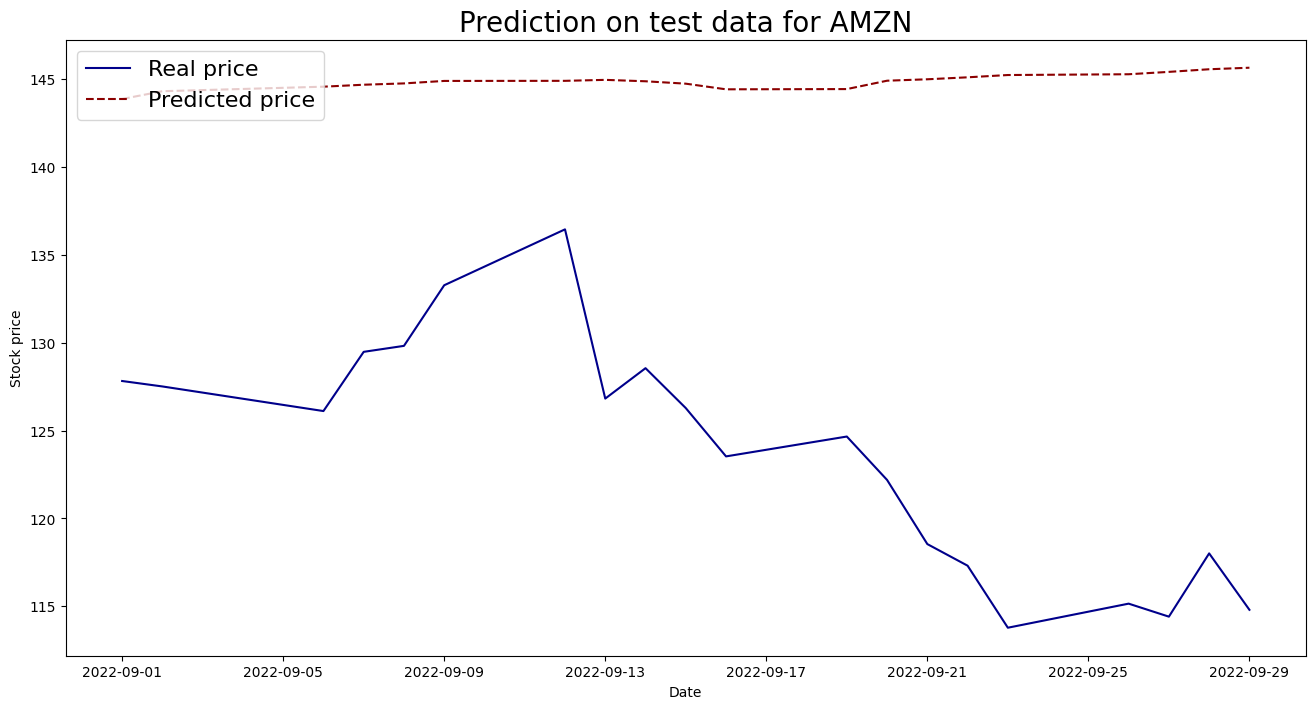

In [518]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)

# Cross validation:

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
Index: 4089 entries, 48351 to 52439
Data columns (to

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 59.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Number of non-zero values in tfidf_df: 36447


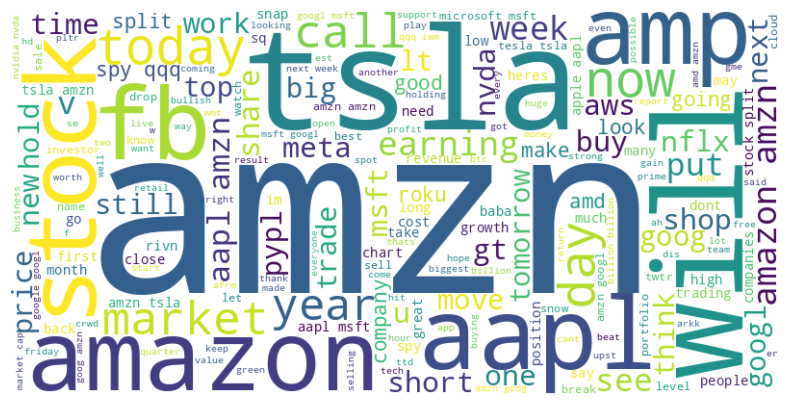

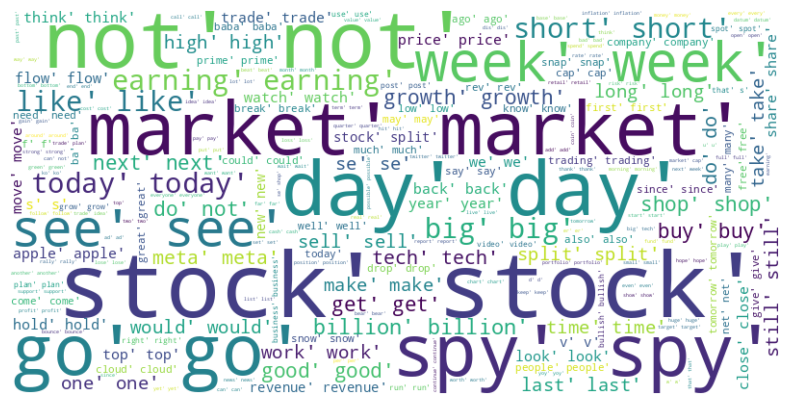

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
Index: 4089 entries, 48351 to 52439
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4089 non-null   object 
 1   compound_score  4089 non-null   float64
dtypes: float64(1), object(1)
memory usage: 95.8+ KB
(365, 1)
(252, 8)


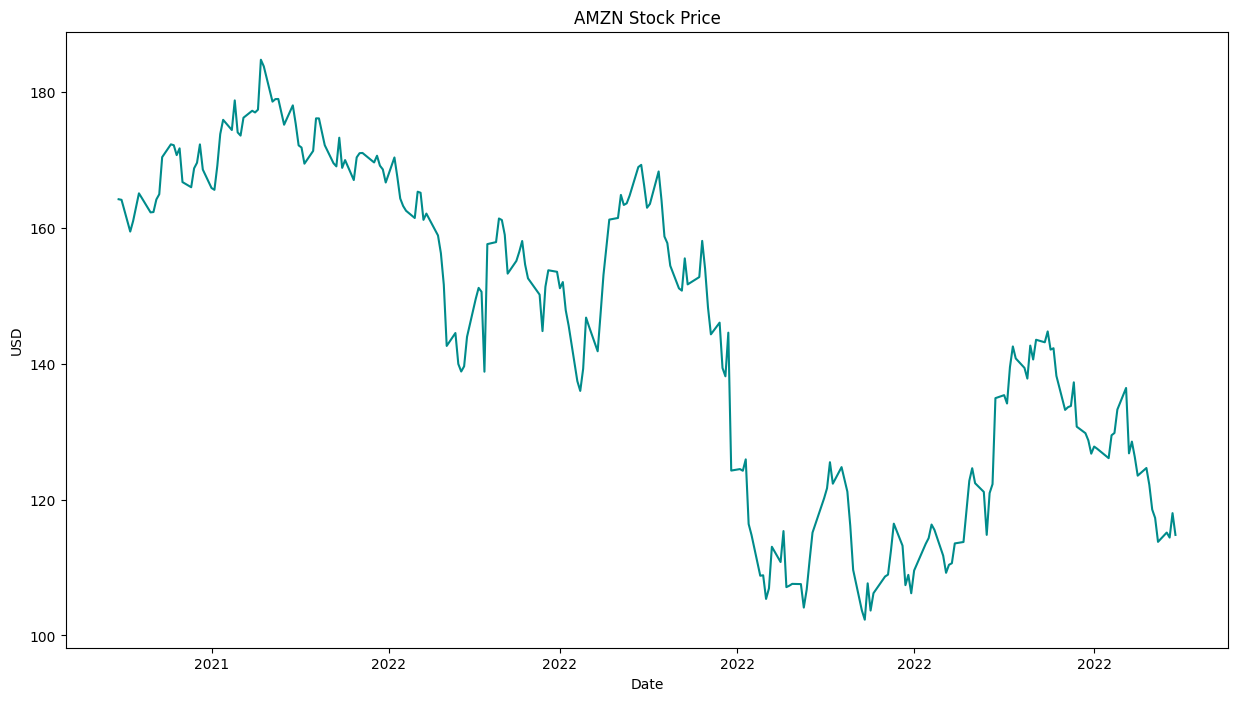

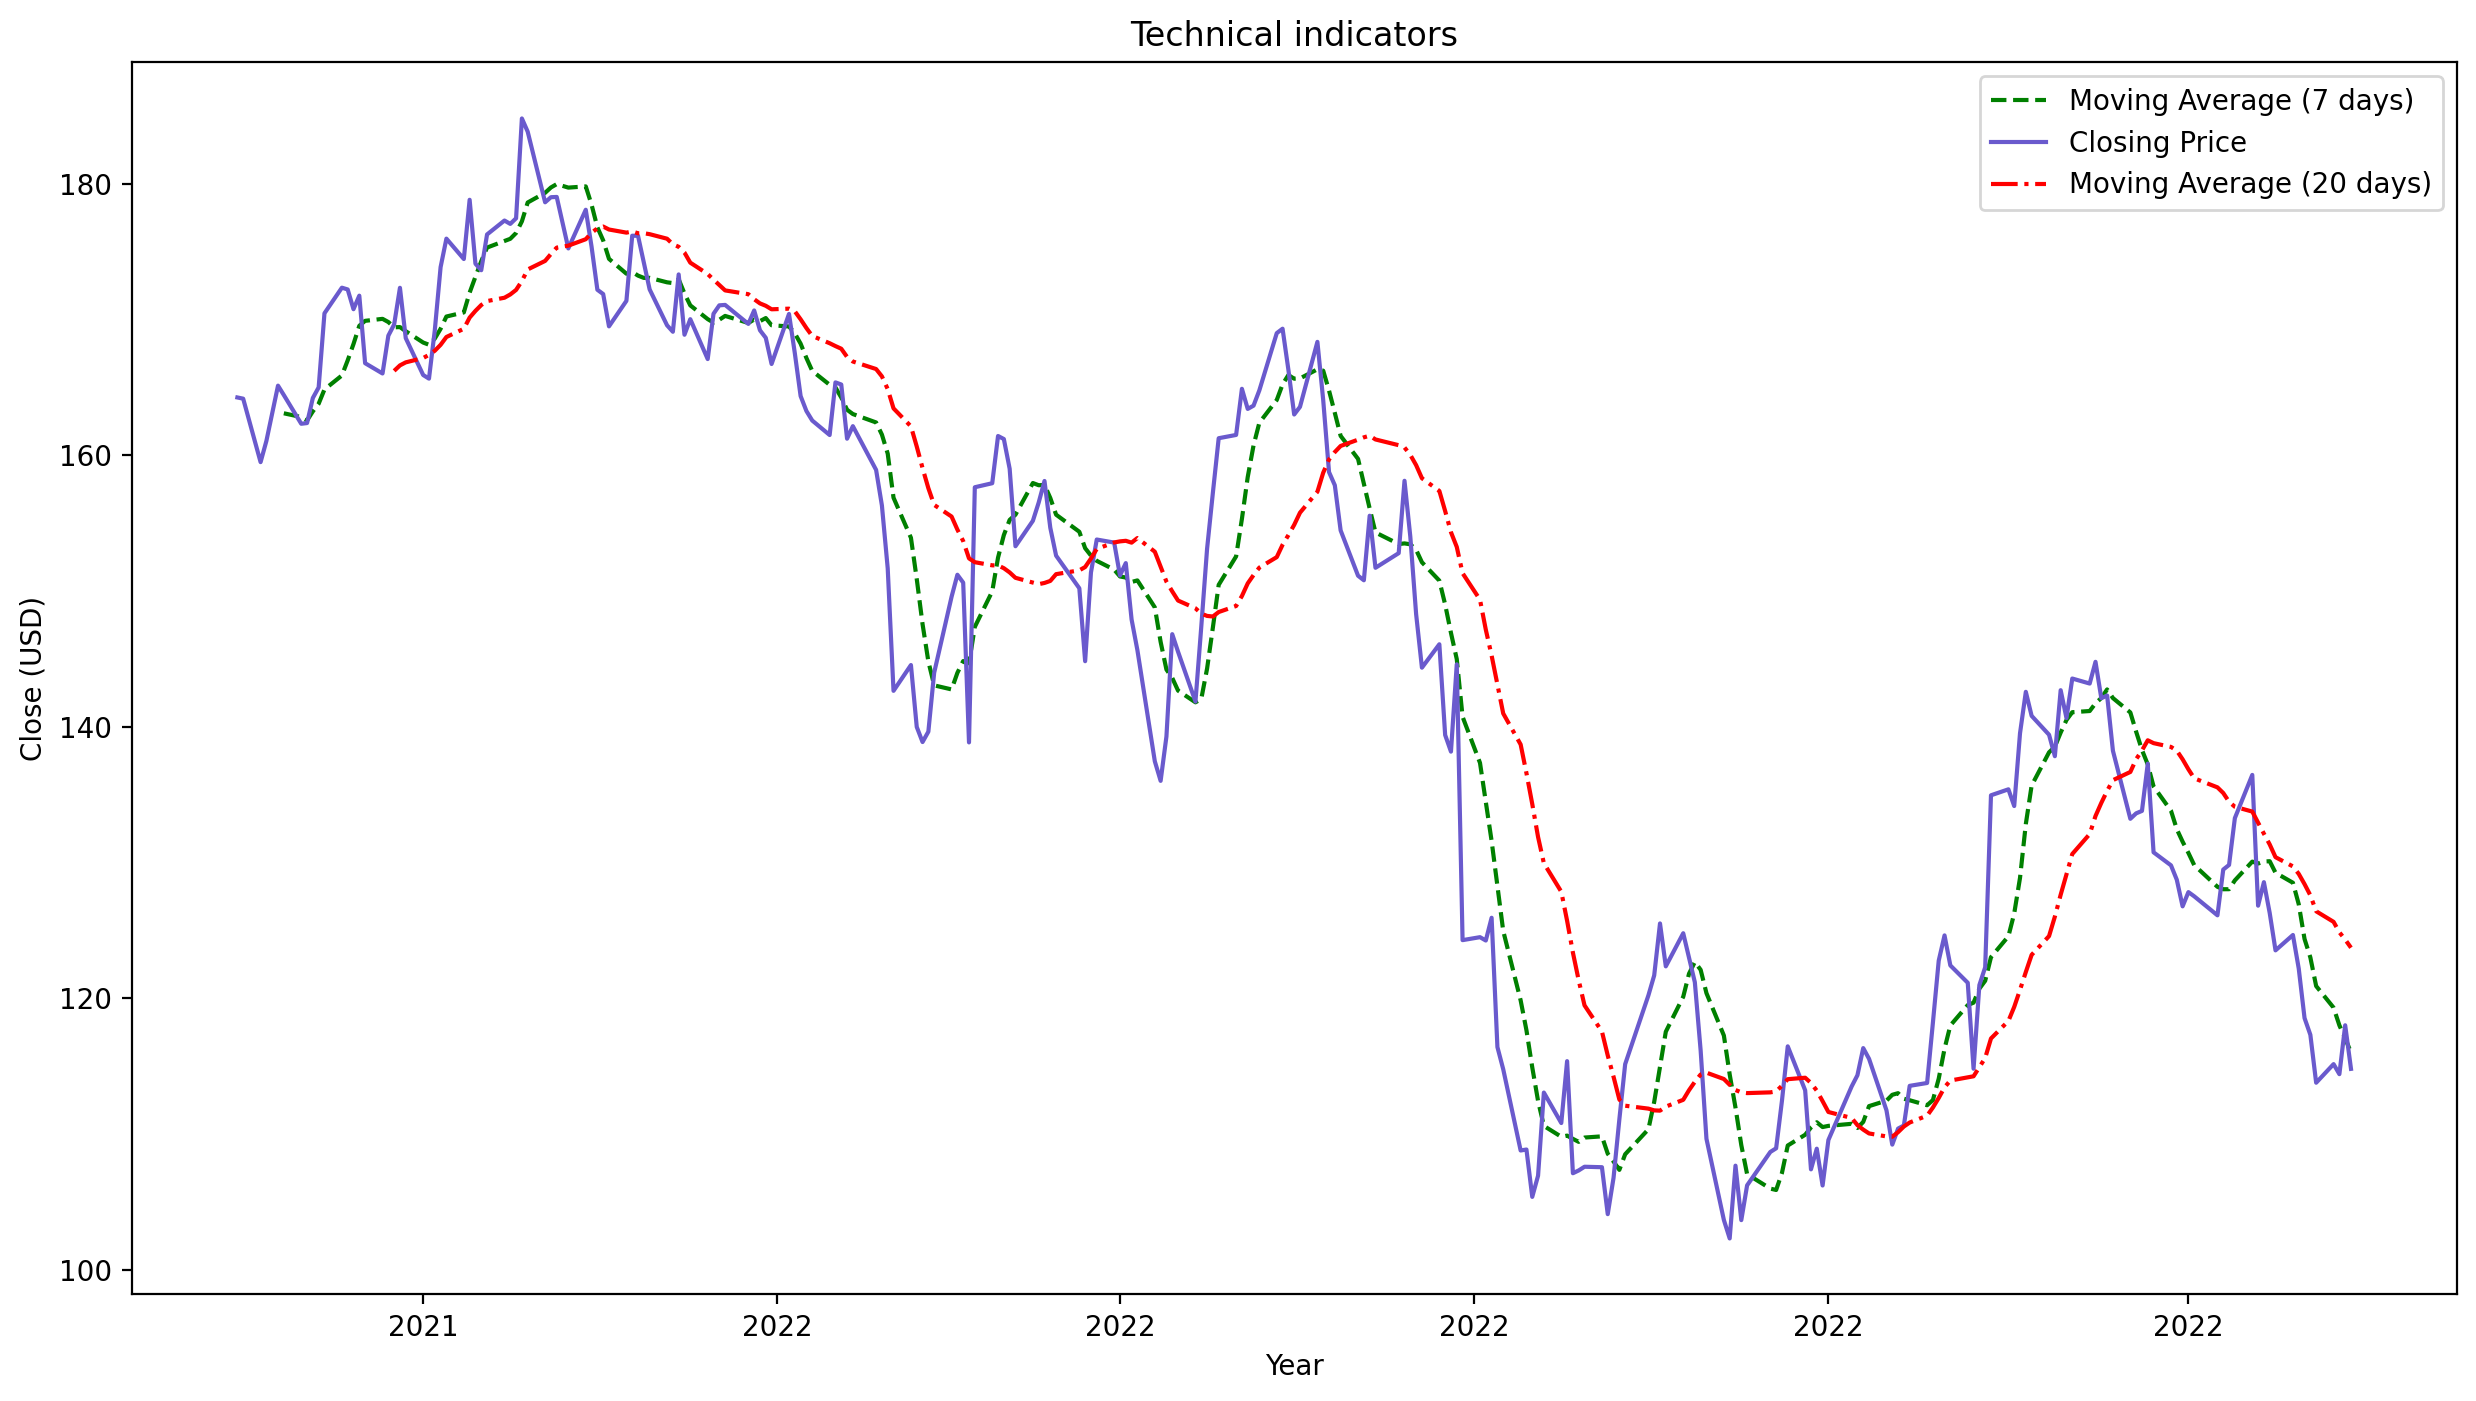

X shape: (227, 5, 15)
y shape: (227, 1)
yc shape: (227, 5, 1)


 10%|█         | 51/500 [00:21<00:50,  8.89it/s]

epoch 50 discriminator_loss 1.2182078 generator_loss 0.8477051


 21%|██        | 103/500 [00:24<00:29, 13.41it/s]

epoch 100 discriminator_loss 1.3931375 generator_loss 0.7027364


 31%|███       | 153/500 [00:27<00:25, 13.73it/s]

epoch 150 discriminator_loss 1.385354 generator_loss 0.69377035


 41%|████      | 203/500 [00:31<00:22, 13.21it/s]

epoch 200 discriminator_loss 1.383731 generator_loss 0.69745994


 50%|█████     | 251/500 [00:34<00:27,  8.97it/s]

epoch 250 discriminator_loss 1.3960812 generator_loss 0.6629533


 61%|██████    | 303/500 [00:38<00:14, 13.26it/s]

epoch 300 discriminator_loss 1.3690896 generator_loss 0.7155512


 71%|███████   | 353/500 [00:41<00:10, 13.71it/s]

epoch 350 discriminator_loss 1.3640039 generator_loss 0.7079635


 81%|████████  | 403/500 [00:44<00:07, 13.50it/s]

epoch 400 discriminator_loss 1.3909729 generator_loss 0.68825585


 91%|█████████ | 453/500 [00:47<00:03, 13.29it/s]

epoch 450 discriminator_loss 1.388387 generator_loss 0.6971754


100%|██████████| 500/500 [00:51<00:00,  9.73it/s]


epoch 500 discriminator_loss 1.3873581 generator_loss 0.69347525


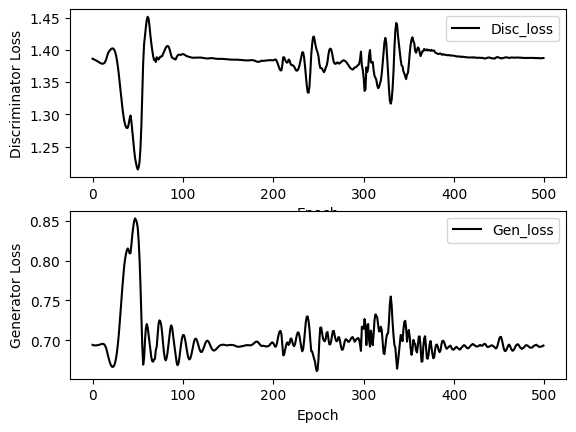

Test RMSE:  3.7410205526033633


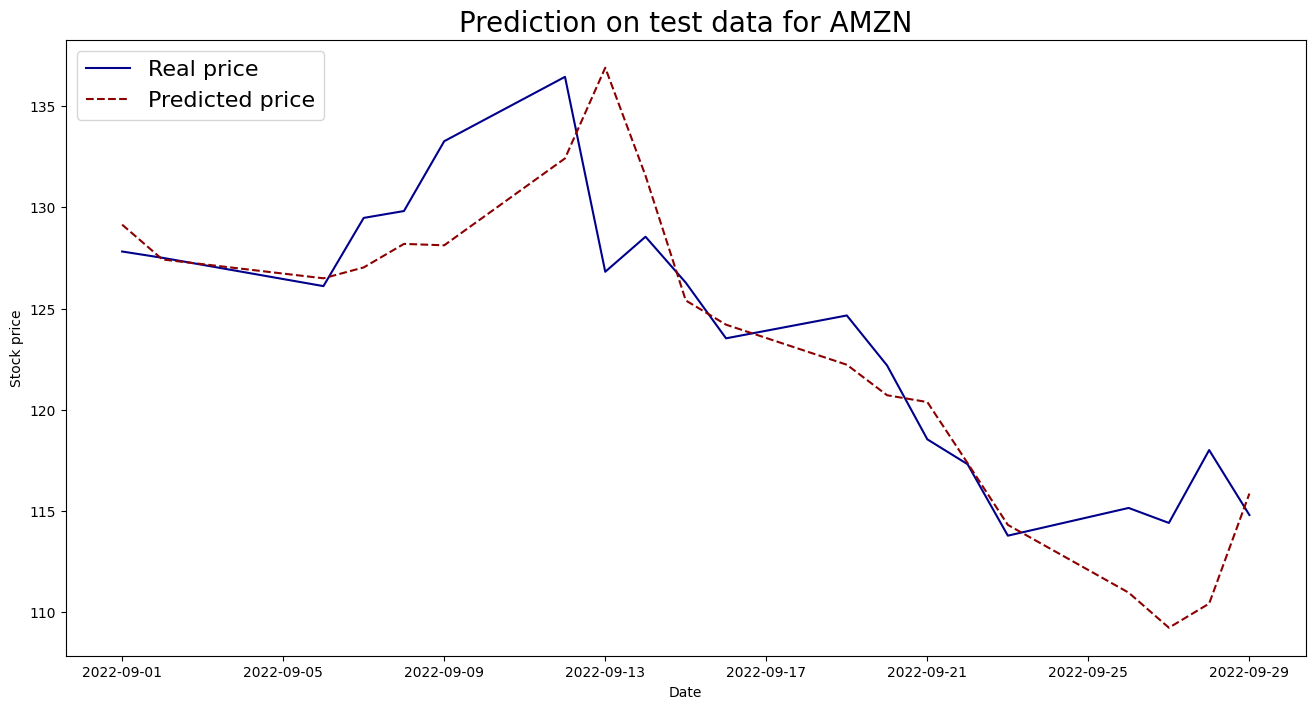

In [522]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as stat
import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('wordnet')

!python -m textblob.download_corpora

from google.colab import drive
drive.mount('/content/drive')

file_path = r'/content/drive/MyDrive/stock_tweets.csv'
train = pd.read_csv(file_path)
train.head()

file_path = r'/content/drive/MyDrive/stock_tweets.csv'
dataset = pd.read_csv(file_path)
dataset.head()

train = train[train['Stock Name'] == 'AMZN']

dataset = dataset[dataset['Stock Name'] == 'AMZN']

"""Handling User Mentions and Hashtags:"""

import re

# Define functions to extract user mentions and hashtags
def extract_user_mentions(text):
    # Use regex to find user mentions (e.g., @username)
    user_mentions = re.findall(r'@(\w+)', text)
    return user_mentions

def extract_hashtags(text):
    # Use regex to find hashtags (e.g., #topic)
    hashtags = re.findall(r'#(\w+)', text)
    return hashtags

# Apply the functions to the 'body' column
train['user_mentions'] = train['Tweet'].apply(extract_user_mentions)
train['hashtags'] = train['Tweet'].apply(extract_hashtags)

train.head()

"""Lower Case:"""

train['Tweet'] = train['Tweet'].str.lower()
train.info()

train.sample(10)

"""Removing punctuations, special characters, URLs:"""

# Define a function to remove punctuation from a text string
def remove_punctuation(text):
    # Use regex to remove all non-alphanumeric characters (including punctuation)
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply the function to the 'text' column
train['Tweet'] = train['Tweet'].apply(remove_punctuation)

train.sample(10)

def remove_special_characters(text):
    # Use regex to remove all non-alphanumeric characters (including special characters)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

train['Tweet'] = train['Tweet'].apply(remove_special_characters)
train.sample(10)

def remove_urls(text):
    # Use regex to remove URLs from the text
    text = re.sub(r'http\S+|www.\S+', '', text)
    return text

train['Tweet'] = train['Tweet'].apply(remove_urls)
train.sample(10)

"""Tokenization"""

nltk.download('punkt')

from nltk.tokenize import word_tokenize
train['tweet_tokens'] = train['Tweet'].apply(word_tokenize)
train.sample(5)

"""Removing gibberish, stop words"""

from nltk.corpus import words

nltk.download('words')
english_words = set(words.words())

def remove_gibberish(tokens):
    cleaned_tokens = [token for token in tokens if token.lower() in english_words]
    return cleaned_tokens

train['tweet_tokens'] = train['tweet_tokens'].apply(remove_gibberish)

nltk.download('all')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

train['tweet_tokens'] = train['tweet_tokens'].apply(remove_stopwords)

train.sample(5)

"""Lemmatization"""

!python -m spacy download en_core_web_sm

import spacy

nlp = spacy.load("en_core_web_sm")

def lemmatize_tokens(tokens):
    text = " ".join(tokens)
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return lemmas

train['lemmatized_tweets'] = train['tweet_tokens'].apply(lemmatize_tokens)
train.sample(5)

"""N-Grams"""

from nltk.util import ngrams

n_gram_order = 2

def extract_ngrams(tokens, n):
    if len(tokens) >= n:
        return list(ngrams(tokens, n))
    else:
        return []

train['bigrams'] = train['lemmatized_tweets'].apply(lambda x: extract_ngrams(x, n_gram_order))
train.sample(10)

n_gram_order = 3

def extract_ngrams(tokens, n):
    if len(tokens) >= n:
        return list(ngrams(tokens, n))
    else:
        return []

train['trigrams'] = train['lemmatized_tweets'].apply(lambda x: extract_ngrams(x, n_gram_order))
train.head(10)

"""TF-IDF"""

from sklearn.feature_extraction.text import TfidfVectorizer

train['tfidf_text'] = train['lemmatized_tweets'].apply(lambda tokens: ' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(train['tfidf_text'])
tfidf_features = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_features)
tfidf_df.head()

non_zero_count = np.count_nonzero(tfidf_df.values)
print("Number of non-zero values in tfidf_df:", non_zero_count)

train.head(10)

"""WordCloud"""

#Unigram cloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'tweet' column contains the text data
text_data = ' '.join(train['Tweet'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

bigram_text = ' '.join([' '.join(map(str, bigrams)) for bigrams in train['bigrams']])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(bigram_text)

# Display the bigram word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

"""#VADER Sentiment Analysis"""

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment

def get_sentiment_scores(text):
    # Join the list of lemmatized words into a single string
    text = ' '.join(text)
    sentiment = analyzer.polarity_scores(text)
    return sentiment

train['sentiment_scores'] = train['lemmatized_tweets'].apply(get_sentiment_scores)
train['compound_score'] = train['sentiment_scores'].apply(lambda x: x['compound'])
train.sample(10)

"""#Stock prediction"""

# dataset.head()
train['tweets'] = dataset['Tweet']
train.head()

analyzer = SentimentIntensityAnalyzer()

# Define a function to get sentiment scores
def get_sentiment_scores(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment

# Apply sentiment analysis to the 'text' column and create new columns for sentiment scores
train['sentiment_scores'] = train['tweets'].apply(get_sentiment_scores)

# Extract the compound sentiment score
train['compound_score'] = train['sentiment_scores'].apply(lambda x: x['compound'])

stock_tweets = train[['Date','compound_score']]
stock_tweets.sample(10)

stock_tweets.shape

stock_tweets['Date'] = pd.to_datetime(stock_tweets['Date'])
stock_tweets['Date'] = stock_tweets['Date'].dt.date
stock_tweets.head()

stock_tweets.info()

twitter_df = stock_tweets.groupby([stock_tweets['Date']]).mean()
print(twitter_df.shape)
twitter_df.sample(10)

file_path = r'/content/drive/MyDrive/stock_yfinance_data.csv'
stocks = pd.read_csv(file_path)
stocks.head()

stock_name = 'AMZN'

stock_df = stocks[stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

final_df.head()

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter  # Import DateFormatter

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

"""#Adding technical indicators
MA(7) stans for Moving Average for past 7 days, whereas MA(20) means Moving Average for past 20 days.

EMA is Exponential Moving average and we can calculate it as:

EMA_t = Pclose + (EMA_t-1 (100 - P))* Bollinger Bands are calculated as:

middle line: stdev(MA(20)) upper bound: MA(20) + 2stdev(MA(20)) lower bound: MA(20) - 2stdev(MA(20))
"""

def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

tech_ind(tech_df)

dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

def normalize_data(df, range, target_column):

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

from sklearn.preprocessing import MinMaxScaler
import pickle  # Import the pickle module

X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True,
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    #cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())


        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())

        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)

    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

## Test Code

@tf.function

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
    plt.show()

learning_rate = 5e-4
epochs = 500

g_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])

plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)

tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)

predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')

predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 96.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Fold 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
Validation MSE: 0.0350
Validation RMSE: 0.1871
Fold 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
Validation MSE: 0.1478
Validation RMSE: 0.3844
Fold 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
Validation MSE: 0.0259
Validation RMSE: 0.1608
Fold 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Validation MSE: 0.0588
Validation RMSE: 0.2424
Fold 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Validation MSE: 0.0462
Validation RMSE: 0.2149
Average MSE: 0.0627
Average RMSE: 0.2379


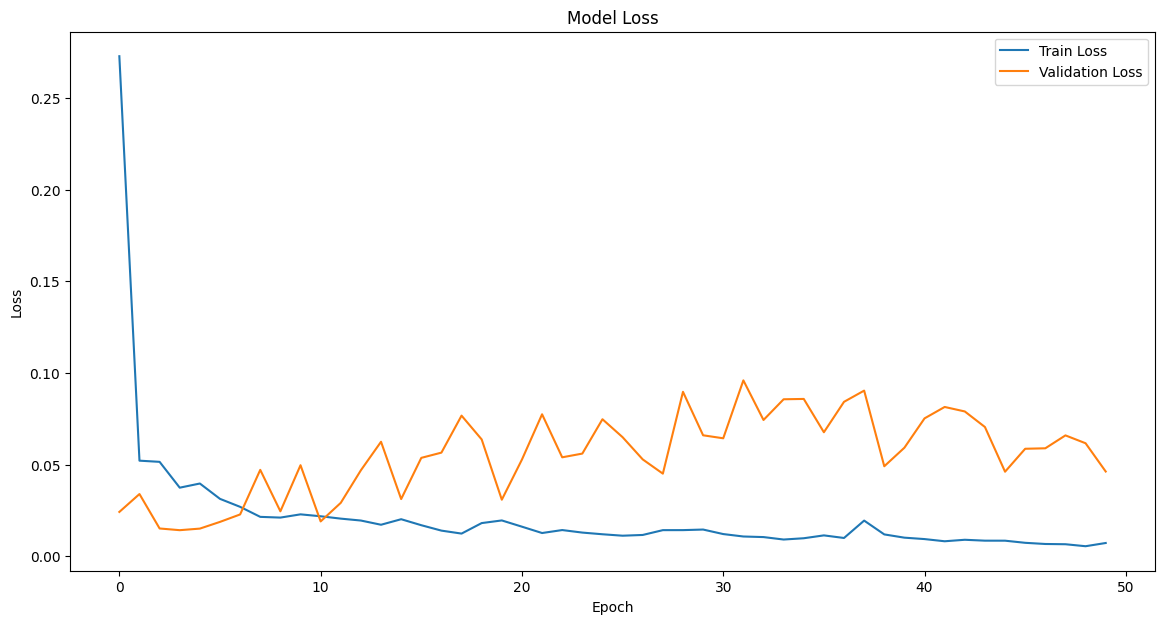

In [525]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import words, stopwords
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Conv1D, LeakyReLU
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from pickle import dump, load
from tqdm import tqdm

# Data loading and preprocessing
file_path = r'/content/drive/MyDrive/stock_tweets.csv'
train = pd.read_csv(file_path)
train = train[train['Stock Name'] == 'AMZN']

def extract_user_mentions(text):
    return re.findall(r'@(\w+)', text)

def extract_hashtags(text):
    return re.findall(r'#(\w+)', text)

train['user_mentions'] = train['Tweet'].apply(extract_user_mentions)
train['hashtags'] = train['Tweet'].apply(extract_hashtags)
train['Tweet'] = train['Tweet'].str.lower()

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def remove_urls(text):
    return re.sub(r'http\S+|www.\S+', '', text)

train['Tweet'] = train['Tweet'].apply(remove_punctuation)
train['Tweet'] = train['Tweet'].apply(remove_special_characters)
train['Tweet'] = train['Tweet'].apply(remove_urls)

nltk.download('punkt')
train['tweet_tokens'] = train['Tweet'].apply(word_tokenize)

nltk.download('words')
english_words = set(words.words())

def remove_gibberish(tokens):
    return [token for token in tokens if token.lower() in english_words]

train['tweet_tokens'] = train['tweet_tokens'].apply(remove_gibberish)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

train['tweet_tokens'] = train['tweet_tokens'].apply(remove_stopwords)

!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

def lemmatize_tokens(tokens):
    text = " ".join(tokens)
    doc = nlp(text)
    return [token.lemma_ for token in doc]

train['lemmatized_tweets'] = train['tweet_tokens'].apply(lemmatize_tokens)

from nltk.util import ngrams

def extract_ngrams(tokens, n):
    if len(tokens) >= n:
        return list(ngrams(tokens, n))
    else:
        return []

n_gram_order = 2
train['bigrams'] = train['lemmatized_tweets'].apply(lambda x: extract_ngrams(x, n_gram_order))

n_gram_order = 3
train['trigrams'] = train['lemmatized_tweets'].apply(lambda x: extract_ngrams(x, n_gram_order))

from sklearn.feature_extraction.text import TfidfVectorizer

train['tfidf_text'] = train['lemmatized_tweets'].apply(lambda tokens: ' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(train['tfidf_text'])
tfidf_features = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_features)

train['sentiment_scores'] = train['lemmatized_tweets'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(' '.join(x)))
train['compound_score'] = train['sentiment_scores'].apply(lambda x: x['compound'])

stock_tweets = train[['Date', 'compound_score']]
stock_tweets['Date'] = pd.to_datetime(stock_tweets['Date'])
stock_tweets['Date'] = stock_tweets['Date'].dt.date
twitter_df = stock_tweets.groupby([stock_tweets['Date']]).mean()

file_path = r'/content/drive/MyDrive/stock_yfinance_data.csv'
stocks = pd.read_csv(file_path)
stock_name = 'AMZN'
stock_df = stocks[stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])

def get_tech_ind(data):
    data['MA7'] = data['Close'].rolling(window=7).mean()
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['MACD'] = data['Close'].ewm(span=26).mean() - data['Open'].ewm(span=12, adjust=False).mean()
    data['20SD'] = data['Close'].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)
    data['EMA'] = data['Close'].ewm(com=0.5).mean()
    data['logmomentum'] = np.log(data['Close'] - 1)
    return data

tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:].reset_index(drop=True)

dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Date'] = dataset['Date'].map(pd.Timestamp.timestamp)
numerical_columns = dataset.select_dtypes(include=['float64', 'int64']).columns
dataset_numerical = dataset[numerical_columns]


def normalize_data(df, range, target_column):
    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])
    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)
    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))
    return X_scale_dataset, y_scale_dataset

def batch_data(x_data, y_data, batch_size, predict_period):
    X_batched, y_batched, yc = [], [], []
    for i in range(0, len(x_data), 1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)
    return np.array(X_batched), np.array(y_batched), np.array(yc)

def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

def predict_index(dataset, X_train, batch_size, prediction_period):
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index
    return train_predict_index, test_predict_index

def make_generator_model(input_dim, output_dim, feature_size):
    model = Sequential([
        LSTM(units=1024, return_sequences=True, input_shape=(input_dim, feature_size), recurrent_dropout=0.3),
        LSTM(units=512, return_sequences=True, recurrent_dropout=0.3),
        LSTM(units=256, return_sequences=True, recurrent_dropout=0.3),
        LSTM(units=128, return_sequences=True, recurrent_dropout=0.3),
        LSTM(units=64, recurrent_dropout=0.3),
        Dense(32),
        Dense(16),
        Dense(8),
        Dense(units=output_dim)
    ])
    return model

def make_discriminator_model(input_dim):
    cnn_net = Sequential([
        Conv1D(8, input_shape=(input_dim + 1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
        Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
        Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
        Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
        tf.keras.layers.Flatten(),
        Dense(512, activation=LeakyReLU(alpha=0.01)),
        Dense(256, activation=LeakyReLU(alpha=0.01)),
        Dense(128, activation=LeakyReLU(alpha=0.01)),
        Dense(64, activation=LeakyReLU(alpha=0.01)),
        Dense(1, activation='sigmoid')
    ])
    return cnn_net

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 50
batch_size = 32
predict_period = 1

# Store metrics
all_mse = []
all_rmse = []

for fold, (train_index, val_index) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1}/{kf.n_splits}")

    train_data, val_data = dataset.iloc[train_index], dataset.iloc[val_index]
    X_train, y_train = normalize_data(train_data, (0, 1), 'Close')
    X_val, y_val = normalize_data(val_data, (0, 1), 'Close')

    X_train, y_train, _ = batch_data(X_train, y_train, batch_size, predict_period)
    X_val, y_val, _ = batch_data(X_val, y_val, batch_size, predict_period)

    model = make_generator_model(X_train.shape[1], 1, X_train.shape[2])
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)

    # Predict on validation set
    val_predictions = model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = np.sqrt(val_mse)

    all_mse.append(val_mse)
    all_rmse.append(val_rmse)

    print(f"Validation MSE: {val_mse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")

print(f"Average MSE: {np.mean(all_mse):.4f}")
print(f"Average RMSE: {np.mean(all_rmse):.4f}")

# Plotting example results from the last fold
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [526]:
# def plot_results(Real_price, Predicted_price, index_train):
#     train_predict_index = index_train

#     rescaled_Real_price = y_scaler.inverse_transform(Real_price)
#     rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

#     predict_result = pd.DataFrame()
#     for i in range(rescaled_Predicted_price.shape[0]):
#         y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
#         predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

#     real_price = pd.DataFrame()
#     for i in range(rescaled_Real_price.shape[0]):
#         y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
#         real_price = pd.concat([real_price, y_train], axis=1, sort=False)

#     predict_result['predicted_mean'] = predict_result.mean(axis=1)
#     real_price['real_mean'] = real_price.mean(axis=1)

#     plt.figure(figsize=(16, 8))
#     plt.plot(real_price["real_mean"], color='#00008B')
#     plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
#     plt.xlabel("Date")
#     plt.ylabel("Stock price")
#     plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
#     plt.title("Training Results", fontsize=20)
#     plt.show()

#     predicted = predict_result["predicted_mean"]
#     real = real_price["real_mean"]
#     RMSE = np.sqrt(mean_squared_error(predicted, real))
#     print('Train RMSE: ', RMSE)


# def plot_test_data(Real_test_price, Predicted_test_price, index_test):
#     test_predict_index = index_test

#     rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
#     rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

#     predict_result = pd.DataFrame()
#     for i in range(rescaled_Predicted_price.shape[0]):
#         y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
#         predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

#     real_price = pd.DataFrame()
#     for i in range(rescaled_Real_price.shape[0]):
#         y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
#         real_price = pd.concat([real_price, y_train], axis=1, sort=False)

#     predict_result['predicted_mean'] = predict_result.mean(axis=1)
#     real_price['real_mean'] = real_price.mean(axis=1)

#     predicted = predict_result["predicted_mean"]
#     real = real_price["real_mean"]
#     RMSE = np.sqrt(mean_squared_error(predicted, real))
#     print('Test RMSE: ', RMSE)
#     print(predicted)

#     plt.figure(figsize=(16, 8))
#     plt.plot(real_price["real_mean"], color='#00008B')
#     plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
#     plt.xlabel("Date")
#     plt.ylabel("Stock price")
#     plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
#     plt.title(f"Test Data Prediction for {stock_name}", fontsize=20)
#     plt.show()
